# SI 618 - Homework #7: Classifiers
or: How I Learned to Stop Worrying and Love Machine Learning

v.20210404.1.CT

This is, perhaps, one of the most exciting homework assignments that you have
encountered in this course!

You are going to try your hand at a Kaggle competition to predict Titanic survivorship.
(Recall that we've played with Titanic data earlier in this course -- this data set is
slightly different.)

(NOTE: if you prefer to not submit your work to the Kaggle competition that's fine --
just contact Chris via email (cteplovs@umich.edu) and we will work out an alternative.)

To start with, make sure you have a [Kaggle](https://www.kaggle.com/) account, 
then navigate to the [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic/overview) project page.

We'll view the [introductory video](https://www.youtube.com/watch?v=8yZMXCaFshs) 
together in class.

The basic steps for this assignment are outlined in the video:

1. Accept the rules and join the competition
2. Download the data (from the data tab of the competition page)
3. Understand the problem
4. EDA (Exploratory Data Analysis)
5. Train, tune, and ensemble (!) your machine learning models
6. Upload your prediction as a submission on Kaggle and receive an accuracy score

additionally, you will

7. Upload your final notebook to Canvas and report your best accuracy score.  

Note that class grades are not entirely dependent on your accuracy score.  
All models that achieve 75% accuracy will receive full points for 
the accuracy component of this assignment.

Rubric:

1. (20 points) EDA
2. (60 points) Train, tune, and ensemble machine learning models
3. (10 points) Accuracy score based on Kaggle submission report (or alternative, see NOTE above).
4. (10 points) PEP-8, grammar, spelling, style, etc.

Some additional notes:

1. If you use another notebook, code, or approaches be sure to reference the original work. (Note that we recommend you study existing Kaggle notebooks before starting your own work.)
2. You can help each other but in the end you must submit your own work, both to Kaggle and to Canvas.

Some additional resources:

* "ensemble" your models with a [VotingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)
* a good primer on [feature engineering](https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/)
* There are a lot of good [notebooks to study](https://www.kaggle.com/c/titanic/notebooks) (check the number of upvotes to help guide your exploration)

## GOOD LUCK!
(and don't cheat)

One final note:  Your submission should be a self-contained notebook that is NOT based
on this one.  Studying the existing Kaggle competition notebooks should 
give you a sense of what makes a "good" notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import plotly.graph_objects as gp
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statistics
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import WhiteKernel
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
sns.set(style = "darkgrid")

# 1. EDA

In [4]:
titanic = pd.read_csv("./data/titanic_train.csv")

In [5]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


There is a total of 12 columns, but since PassengerId is just an ID, so let's delete the column.

In [6]:
titanic_id = titanic["PassengerId"]
titanic.drop("PassengerId", axis = 1, inplace = True)
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


There are 10 independent variables and 1 dependent variable.
- Dependent variable: Survived
- Independent variables:
    - Pclass: Ticket class. (1 = 1st, 2 = 2nd, 3 = 3rd)
    - Name
    - Sex
    - Age
    - SibSp: # of siblings / spouses aboard the Titanic
    - Parch: # of parents / children aboard the Titanic
    - Ticket: Ticket numberc
    - Fare: Passenger fare
    - Cabin: Cabin number
    - Embarked: Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

And we can categorize independent variables into 3 different categories:     
- Ticket related columns: Pclass, Ticket, Fare, Cabin, Embarked       
- Person related columns: Name, Sex, Age      
- Family related columns: SibSp, Parch       

## 1.0. Change column names

For just convenience, let's change the column names.

- Dependent variable: Survived -> is_survived
- Independent variables:
    - Pclass: Ticket class. (1 = 1st, 2 = 2nd, 3 = 3rd) -> p_class
    - Name -> name
    - Sex -> sex
    - Age -> age
    - SibSp: # of siblings / spouses aboard the Titanic -> num_sb_sp
    - Parch: # of parents / children aboard the Titanic -> num_pr_ch
    - Ticket: Ticket number -> ticket_number
    - Fare: Passenger fare -> ticket_fare
    - Cabin: Cabin number -> cabin_number
    - Embarked: Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton) -> embark_port

In [7]:
titanic.rename(columns = {"Survived" : "is_survived", 
                          "Pclass" : "p_class",
                          "Name" : "name",
                          "Sex" : "sex", 
                          "Age" : "age",
                          "SibSp" : "num_sb_sp",
                          "Parch" : "num_pr_ch",
                          "Ticket" : "ticket_number",
                          "Fare" : "ticket_fare",
                          "Cabin" : "cabin_number",
                          "Embarked" : "embark_port"}, inplace = True)
titanic.head()

,is_survived,p_class,name,sex,age,num_sb_sp,num_pr_ch,ticket_number,ticket_fare,cabin_number,embark_port
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 1.1. Check missing values

In [8]:
np.sum(titanic.isnull(), axis = 0).sort_values(ascending = False)

cabin_number     687
age              177
embark_port        2
is_survived        0
p_class            0
name               0
sex                0
num_sb_sp          0
num_pr_ch          0
ticket_number      0
ticket_fare        0
dtype: int64

- Almost every row doesn't have a cabin_number value.
- age is the next most missing column.
- embark_port only has 2 missing values.


## 1.1. Ticket related columns: p_class, ticket_number, ticket_fare, cabin_number, embark_port

### p_class

In [9]:
titanic["p_class"].value_counts()

3    491
1    216
2    184
Name: p_class, dtype: int64

- 1st class passengers: 216
- 2nd class passengers: 184
- 3rd class passengers: 491

In [10]:
np.sum(titanic["p_class"].isnull())

0

- There is no missing value in the p_class column

### p_class ~ is_survived

Let's check the relationship between p_class and is_survived.

In [11]:
p_class_is_survived = titanic.groupby(["p_class","is_survived"]).count().name.unstack().reset_index()
p_class_is_survived = p_class_is_survived.rename_axis(None, axis = 1)
p_class_is_survived["total"] = p_class_is_survived[0] + p_class_is_survived[1]
p_class_is_survived["ratio"] = np.round(p_class_is_survived[1] / p_class_is_survived.total, 2)
p_class_is_survived

,p_class,0,1,total,ratio
0,1,80,136,216,0.63
1,2,97,87,184,0.47
2,3,372,119,491,0.24


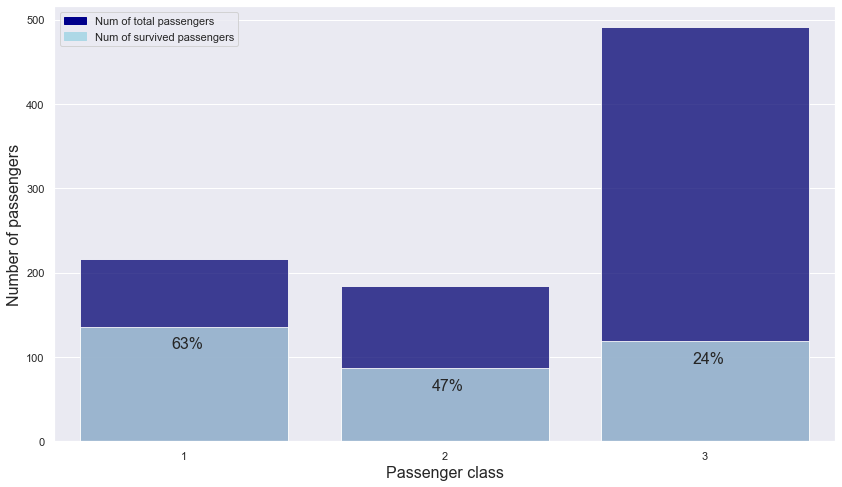

In [12]:
plt.figure(figsize = (14, 8))

# bar graph for total students
color = "darkblue"
ax1 = sns.barplot(x = "p_class", y = "total", color = color, alpha = 0.8, \
                  data = p_class_is_survived)
top_bar = mpatches.Patch(color = color, label = 'Num of total passengers')

# bar graph for students have research experience
color = "lightblue"
ax2 = sns.barplot(x = "p_class", y = 1,  color = color, alpha = 0.8, \
                  data = p_class_is_survived)
ax2.set_xlabel("Passenger class", fontsize = 16)
ax2.set_ylabel("Number of passengers", fontsize = 16)
low_bar = mpatches.Patch(color = color, label = 'Num of survived passengers')

# ratio
plt.text(s = "63%", x = -0.05, y = 110, fontsize = 16)
plt.text(s = "47%", x = 0.95, y = 60, fontsize = 16)
plt.text(s = "24%", x = 1.95, y = 92, fontsize = 16)

plt.legend(handles=[top_bar, low_bar])
plt.show()

- As the class goes up one level, the chance of surviving increases by about 1.5 times.              
    -> passenger class is important in predicting survival

### ticket_number

In [13]:
np.sum(titanic["ticket_number"].isnull())

0

- There is no missing value in the ticket_number column

In [14]:
titanic.ticket_number

0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
3                113803
4                373450
             ...       
886              211536
887              112053
888          W./C. 6607
889              111369
890              370376
Name: ticket_number, Length: 891, dtype: object

- Ticket numbers have a form of alphabet + number or just number.      
    -> Let's divide the ticket number into ticket_number_alphabet and ticket_number_number.

In [15]:
titanic.loc[titanic["ticket_number"].str.split(" ").str[1].isnull() == False, "ticket_number_alphabet"] = titanic[titanic["ticket_number"].str.split(" ").str[1].isnull() == False].ticket_number.str.split(" ").str[0]
titanic["ticket_number_alphabet"] = titanic.ticket_number_alphabet.fillna("non")

In [16]:
titanic.head()

,is_survived,p_class,name,sex,age,num_sb_sp,num_pr_ch,ticket_number,ticket_fare,cabin_number,embark_port,ticket_number_alphabet
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,A/5
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,PC
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,STON/O2.
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,non
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,non


In [17]:
titanic.loc[titanic.ticket_number_alphabet == "non", "ticket_number_number"] = titanic[titanic.ticket_number_alphabet == "non"]["ticket_number"].str.split(" ").str[0]
titanic.loc[titanic.ticket_number_alphabet != "non", "ticket_number_number"] = titanic[titanic.ticket_number_alphabet != "non"]["ticket_number"].str.split(" ").str[1]
titanic.loc[titanic.ticket_number.str.split(" ").str[2].isnull() == False, "ticket_number_number"] = titanic[titanic.ticket_number.str.split(" ").str[2].isnull() == False].ticket_number.str.split(" ").str[2]

In [18]:
titanic[["ticket_number", "ticket_number_alphabet", "ticket_number_number"]]

,ticket_number,ticket_number_alphabet,ticket_number_number
0,A/5 21171,A/5,21171
1,PC 17599,PC,17599
2,STON/O2. 3101282,STON/O2.,3101282
3,113803,non,113803
4,373450,non,373450
...,...,...,...
886,211536,non,211536
887,112053,non,112053
888,W./C. 6607,W./C.,6607
889,111369,non,111369


Aslo, if we sort the data by ticket number, 

In [19]:
titanic.sort_values("ticket_number")

,is_survived,p_class,name,sex,age,num_sb_sp,num_pr_ch,ticket_number,ticket_fare,cabin_number,embark_port,ticket_number_alphabet,ticket_number_number
504,1,1,"Maioni, Miss. Roberta",female,16.0,0,0,110152,86.500,B79,S,non,110152
257,1,1,"Cherry, Miss. Gladys",female,30.0,0,0,110152,86.500,B77,S,non,110152
759,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,110152,86.500,B77,S,non,110152
262,0,1,"Taussig, Mr. Emil",male,52.0,1,1,110413,79.650,E67,S,non,110413
558,1,1,"Taussig, Mrs. Emil (Tillie Mandelbaum)",female,39.0,1,1,110413,79.650,E67,S,non,110413
...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,0,3,"Harknett, Miss. Alice Phoebe",female,NaN,0,0,W./C. 6609,7.550,NaN,S,W./C.,6609
92,0,1,"Chaffee, Mr. Herbert Fuller",male,46.0,1,0,W.E.P. 5734,61.175,E31,S,W.E.P.,5734
219,0,2,"Harris, Mr. Walter",male,30.0,0,0,W/C 14208,10.500,NaN,S,W/C,14208
540,1,1,"Crosby, Miss. Harriet R",female,36.0,0,2,WE/P 5735,71.000,B22,S,WE/P,5735


- then it seems that rows that have the same ticket number have the same ticket fare. Let's check this hypothesis for all rows.

In [20]:
merged_by_ticket_number = titanic.merge(titanic, on = "ticket_number", how = "left")
merged_by_ticket_number[merged_by_ticket_number.ticket_fare_x != merged_by_ticket_number.ticket_fare_y]

,is_survived_x,p_class_x,name_x,sex_x,age_x,num_sb_sp_x,num_pr_ch_x,ticket_number,ticket_fare_x,cabin_number_x,...,name_y,sex_y,age_y,num_sb_sp_y,num_pr_ch_y,ticket_fare_y,cabin_number_y,embark_port_y,ticket_number_alphabet_y,ticket_number_number_y
248,0,3,"Osen, Mr. Olaf Elon",male,16.0,0,0,7534,9.2167,NaN,...,"Gustafsson, Mr. Alfred Ossian",male,20.0,0,0,9.8458,NaN,S,non,7534
1570,0,3,"Gustafsson, Mr. Alfred Ossian",male,20.0,0,0,7534,9.8458,NaN,...,"Osen, Mr. Olaf Elon",male,16.0,0,0,9.2167,NaN,S,non,7534


- There are only 2 people who have the same ticket number but have different ticket fares. So, I think this case is just an outlier, and we can think that if the ticket number is the same, then the ticket fare is also the same.

If we check some cases that have the same ticket number,

In [21]:
merged_by_ticket_number[["name_x", "name_y", "ticket_fare_x", "ticket_fare_y", "ticket_number"]].sort_values(["ticket_number", "name_x"]).head(20)

,name_x,name_y,ticket_fare_x,ticket_fare_y,ticket_number
460,"Cherry, Miss. Gladys","Cherry, Miss. Gladys",86.50,86.50,110152
461,"Cherry, Miss. Gladys","Maioni, Miss. Roberta",86.50,86.50,110152
462,"Cherry, Miss. Gladys","Rothes, the Countess. of (Lucy Noel Martha Dye...",86.50,86.50,110152
889,"Maioni, Miss. Roberta","Cherry, Miss. Gladys",86.50,86.50,110152
890,"Maioni, Miss. Roberta","Maioni, Miss. Roberta",86.50,86.50,110152
891,"Maioni, Miss. Roberta","Rothes, the Countess. of (Lucy Noel Martha Dye...",86.50,86.50,110152
1345,"Rothes, the Countess. of (Lucy Noel Martha Dye...","Cherry, Miss. Gladys",86.50,86.50,110152
1346,"Rothes, the Countess. of (Lucy Noel Martha Dye...","Maioni, Miss. Roberta",86.50,86.50,110152
1347,"Rothes, the Countess. of (Lucy Noel Martha Dye...","Rothes, the Countess. of (Lucy Noel Martha Dye...",86.50,86.50,110152
1026,"Taussig, Miss. Ruth","Taussig, Mr. Emil",79.65,79.65,110413


- then we can infer that peoples who have the same ticket number are companions who were traveling together. Since if companions are not family members, then this information is not in the num_sb_sp and num_pr_ch columns.     
    -> let's make a new column that shows how many companions were there for each passenger based on ticket number.

In [22]:
titanic = titanic.merge(titanic["ticket_number"].value_counts().reset_index().rename(columns = {"index" : "ticket_number", "ticket_number" : "num_cmp_by_ticket"}), \
                        on = "ticket_number", how = "left")
titanic["num_cmp_by_ticket"] = titanic["num_cmp_by_ticket"] - 1 # only one passenger with no companion has to have value 0
titanic.head()

,is_survived,p_class,name,sex,age,num_sb_sp,num_pr_ch,ticket_number,ticket_fare,cabin_number,embark_port,ticket_number_alphabet,ticket_number_number,num_cmp_by_ticket
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,A/5,21171,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,PC,17599,0
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,STON/O2.,3101282,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,non,113803,1
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,non,373450,0


- But this can be different from the result from the sum of num_sb_sp and num_pr_ch.    
    -> let's cacluate num_cmp_by_sb_sp_pr_ch and compare this value to num_cmp_by_ticket.

In [23]:
titanic["num_cmp_by_sb_sp_pr_ch"] = titanic["num_sb_sp"] + titanic["num_pr_ch"]
titanic[titanic.num_cmp_by_ticket != titanic.num_cmp_by_sb_sp_pr_ch]

,is_survived,p_class,name,sex,age,num_sb_sp,num_pr_ch,ticket_number,ticket_fare,cabin_number,embark_port,ticket_number_alphabet,ticket_number_number,num_cmp_by_ticket,num_cmp_by_sb_sp_pr_ch
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,A/5,21171,0,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,PC,17599,0,1
7,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,non,349909,3,4
10,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S,PP,9549,1,2
16,0,3,"Rice, Master. Eugene",male,2.0,4,1,382652,29.1250,NaN,Q,non,382652,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
866,1,2,"Duran y More, Miss. Asuncion",female,27.0,1,0,SC/PARIS 2149,13.8583,NaN,C,SC/PARIS,2149,0,1
871,1,1,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",female,47.0,1,1,11751,52.5542,D35,S,non,11751,1,2
876,0,3,"Gustafsson, Mr. Alfred Ossian",male,20.0,0,0,7534,9.8458,NaN,S,non,7534,1,0
885,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q,non,382652,4,5


- There are 288 cases where the number of companions based on ticket number is different from the number of companions based on num_sb_sp and num_pr_ch.    
    -> Let's make num_cmp =  max(num_cmp_by_ticket, num_cmp_by_sb_sp_pr_ch)

In [24]:
titanic["num_cmp"] = titanic[["num_cmp_by_ticket", "num_cmp_by_sb_sp_pr_ch"]].max(axis = 1)
titanic.drop(["num_cmp_by_ticket", "num_cmp_by_sb_sp_pr_ch"], axis = 1, inplace = True)

titanic.head()

,is_survived,p_class,name,sex,age,num_sb_sp,num_pr_ch,ticket_number,ticket_fare,cabin_number,embark_port,ticket_number_alphabet,ticket_number_number,num_cmp
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,A/5,21171,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,PC,17599,1
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,STON/O2.,3101282,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,non,113803,1
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,non,373450,0


In [25]:
titanic.shape

(891, 14)

### ticket_number_alphabet

In [26]:
len(titanic.ticket_number_alphabet.unique())

43

In [27]:
titanic.ticket_number_alphabet.value_counts()

non           665
PC             60
C.A.           27
STON/O         12
A/5            10
W./C.           9
CA.             8
SOTON/O.Q.      8
SOTON/OQ        7
A/5.            7
CA              6
STON/O2.        6
C               5
F.C.C.          5
S.O.C.          5
SC/PARIS        5
SC/Paris        4
S.O./P.P.       3
PP              3
A/4.            3
A/4             3
SC/AH           3
A./5.           2
SOTON/O2        2
A.5.            2
WE/P            2
S.C./PARIS      2
P/PP            2
F.C.            1
SC              1
S.W./PP         1
A/S             1
Fa              1
SCO/W           1
SW/PP           1
W/C             1
S.C./A.4.       1
S.O.P.          1
A4.             1
W.E.P.          1
SO/C            1
S.P.            1
C.A./SOTON      1
Name: ticket_number_alphabet, dtype: int64

- There are 42 distinct kinds of prefixes in the ticket number, and almost ticket numbers don't have a prefix alphabet. But it is hard to interpret the ticket number alphabet or to find some relationship with other columns.   
    -> Do not use ticket_number_alphabet

### ticket_number_number ~ p_class | is_survived

Let's check if there is a relationship between ticket_number_number and p_class

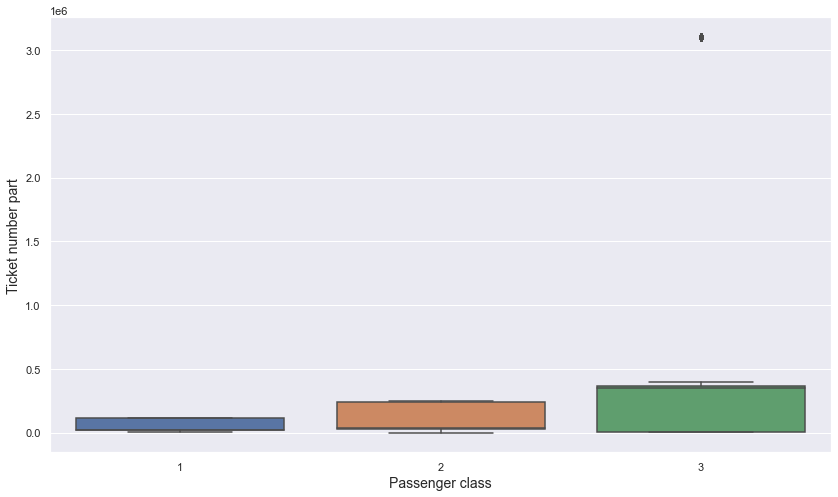

In [28]:
plt.figure(figsize = (14, 8))
sns.boxplot(data = pd.concat([titanic.p_class, titanic[titanic.ticket_number_number != "LINE"].ticket_number_number.astype("int32")], axis = 1), x = "p_class", y = "ticket_number_number")
plt.xlabel("Passenger class", fontsize = 14)
plt.ylabel("Ticket number part", fontsize = 14)
plt.show()

- It is hard to find relationship between ticket_number_number and p_class.        

Let's check if there is a relationship between ticket_number_number and is_survived

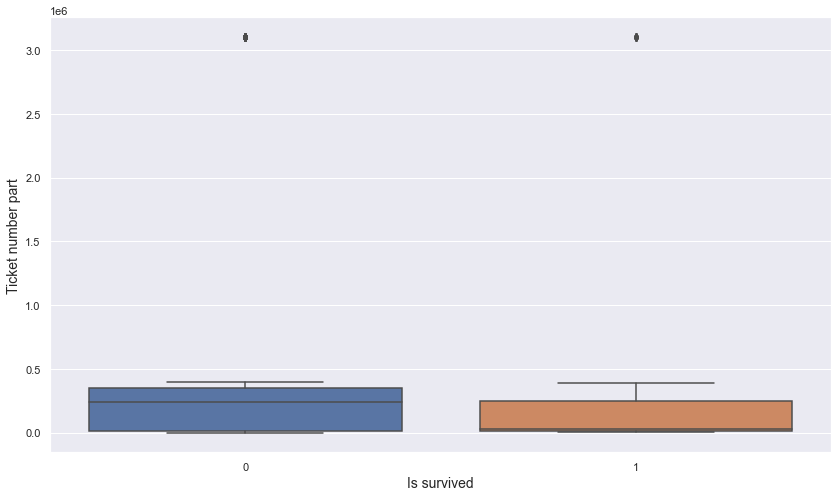

In [29]:
plt.figure(figsize = (14, 8))
sns.boxplot(data = pd.concat([titanic.is_survived, titanic[titanic.ticket_number_number != "LINE"].ticket_number_number.astype("int32")], axis = 1), x = "is_survived", y = "ticket_number_number")
plt.xlabel("Is survived", fontsize = 14)
plt.ylabel("Ticket number part", fontsize = 14)
plt.show()

- It is hard to find relationship between ticket_number_number and p_class.        
    -> Do not use the ticket_number_number

### ticket_fare

In [30]:
np.sum(titanic["ticket_fare"].isnull())

0

- There is no missing value in the ticket_fare column

In [31]:
titanic["ticket_fare"].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: ticket_fare, dtype: float64

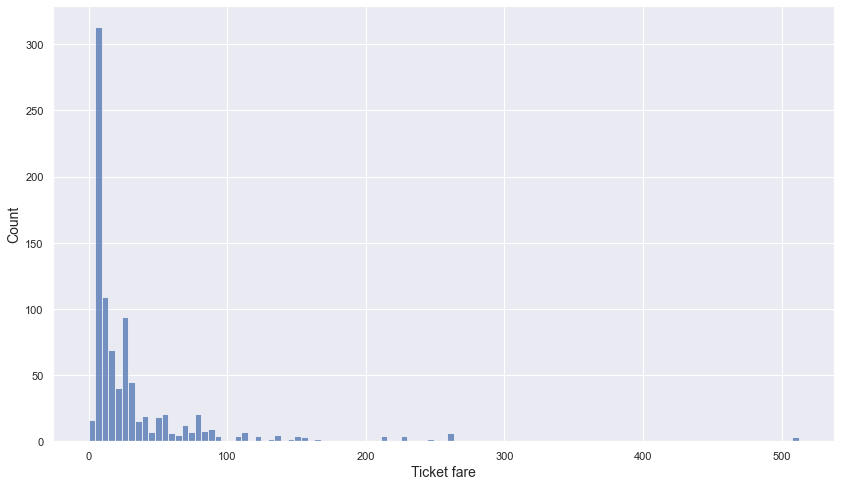

In [32]:
plt.figure(figsize = (14, 8))

sns.histplot(titanic.ticket_fare)
plt.xlabel("Ticket fare", fontsize = 14)
plt.ylabel("Count", fontsize = 14)
plt.show()

- Minimum value is 0 and maximum value is 512.33.
- 75% of ticket fares are under 31.
- These numerical values and the histogram show that the standard deviation is very large.      
    -> Let's check the histogram of ticket fares under the 95% percentile.

In [33]:
ticket_fares_95 = np.percentile(titanic["ticket_fare"], 95)
ticket_fares_95

112.07915

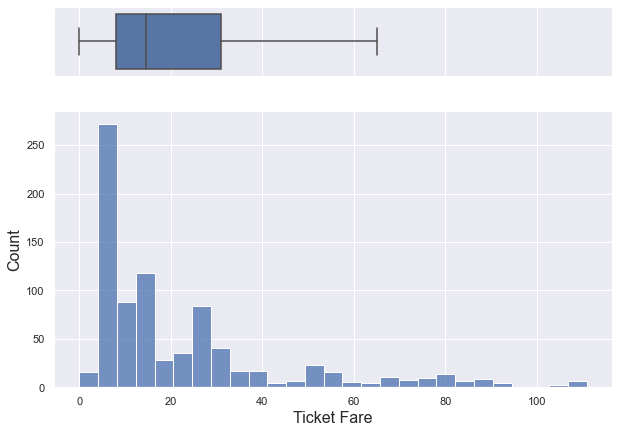

In [34]:
fig, (ax_box, ax_hist) = plt.subplots(2, sharex = True, gridspec_kw = {"height_ratios": (.2, .8)}, figsize = (10, 7))

sns.boxplot(x = titanic.ticket_fare, ax = ax_box, showfliers = False)
sns.histplot(x = titanic[titanic["ticket_fare"] <= ticket_fares_95].ticket_fare, ax = ax_hist)

plt.xlabel("Ticket Fare", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
ax_box.set_xlabel("")

plt.show()

- 50% of ticket fares are under 14 and almost ticket fares are under 30.

Now, let's check outliers

In [35]:
titanic[titanic["ticket_fare"] == 0]

,is_survived,p_class,name,sex,age,num_sb_sp,num_pr_ch,ticket_number,ticket_fare,cabin_number,embark_port,ticket_number_alphabet,ticket_number_number,num_cmp
179,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S,non,LINE,3
263,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S,non,112059,0
271,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S,non,LINE,3
277,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S,non,239853,2
302,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S,non,LINE,3
413,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S,non,239853,2
466,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S,non,239853,2
481,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S,non,239854,0
597,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S,non,LINE,3
633,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S,non,112052,0


- There are only 15 rows whose ticket fare is 0.0. So 0 may mean a missing value.    
    -> In the above ticket_number EDA, we have found that the same ticket numbers have the same ticket fares. So let's check if other rows have non-zero fare with the same ticket numbers as the above table.

In [36]:
for tn in titanic[titanic["ticket_fare"] == 0].ticket_number.unique():
    print(tn, " :", titanic[(titanic["ticket_fare"] != 0) & (titanic.ticket_number == tn)].shape)

LINE  : (0, 14)
112059  : (0, 14)
239853  : (0, 14)
239854  : (0, 14)
112052  : (0, 14)
239856  : (0, 14)
239855  : (0, 14)
112050  : (0, 14)
112058  : (0, 14)
19972  : (0, 14)


- All row whose fare is 0 doesn't have other rows that have the same ticket number as the non-zero fare. So it isn't possible to impute the ticket fare values with ticket number information.       
    -> Since there are no missing values in p_class, let's use p_class to impute the missing value in the ticket_fare column.

### ticket_fare ~ p_class

Let's check relationship between ticket_fare and p_class

In [37]:
titanic.groupby("p_class").ticket_fare.median().reset_index().rename({"ticket_fare" : "ticket_fare_median"}, axis = 1) \
    .merge(titanic.groupby("p_class").ticket_fare.mean().reset_index().rename({"ticket_fare" : "ticket_fare_mean"}, axis = 1), on = "p_class", how = "left")

,p_class,ticket_fare_median,ticket_fare_mean
0,1,60.2875,84.154687
1,2,14.2500,20.662183
2,3,8.0500,13.675550


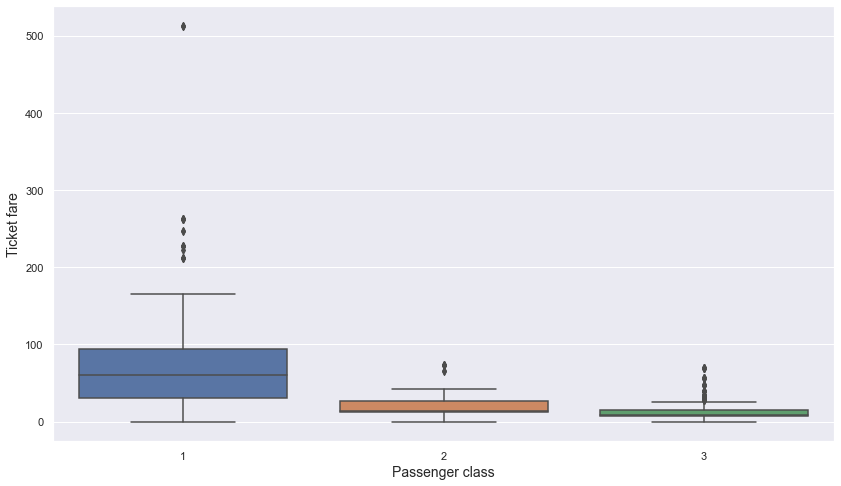

In [38]:
plt.figure(figsize = (14, 8))

sns.boxplot(data = titanic, x = "p_class", y = "ticket_fare")
plt.xlabel("Passenger class", fontsize = 14)
plt.ylabel("Ticket fare", fontsize = 14)
plt.show()

- We can see that there are meaningful differences in mean and median values of ticket fares between passenger classes.     
    -> Since there were no missing values in passenger class, I think it is a good way to impute missing value in ticket fare with the mean or median value of each passenger class. In the above box plot, we can see that there are some extreme values in passenger class = 1. Since mean is affected a lot with extreme values, let's use median instead of mean to impute ticket fare.

In [39]:
p_class_fare_median = titanic.groupby("p_class").ticket_fare.median().reset_index().rename({"ticket_fare" : "ticket_fare_median"}, axis = 1)
p_class_fare_median

,p_class,ticket_fare_median
0,1,60.2875
1,2,14.2500
2,3,8.0500


In [40]:
titanic.loc[(titanic.ticket_fare == 0) & (titanic.p_class == 1), "ticket_fare"] = p_class_fare_median[p_class_fare_median.p_class == 1].ticket_fare_median.values[0]
titanic.loc[(titanic.ticket_fare == 0) & (titanic.p_class == 2), "ticket_fare"] = p_class_fare_median[p_class_fare_median.p_class == 2].ticket_fare_median.values[0]
titanic.loc[(titanic.ticket_fare == 0) & (titanic.p_class == 3), "ticket_fare"] = p_class_fare_median[p_class_fare_median.p_class == 3].ticket_fare_median.values[0]

In [41]:
titanic.shape

(891, 14)

In [42]:
titanic[titanic.ticket_fare == 0]

,is_survived,p_class,name,sex,age,num_sb_sp,num_pr_ch,ticket_number,ticket_fare,cabin_number,embark_port,ticket_number_alphabet,ticket_number_number,num_cmp


In [43]:
titanic[titanic.ticket_fare.isnull()]

,is_survived,p_class,name,sex,age,num_sb_sp,num_pr_ch,ticket_number,ticket_fare,cabin_number,embark_port,ticket_number_alphabet,ticket_number_number,num_cmp


### ticket_fare ~ is_survived

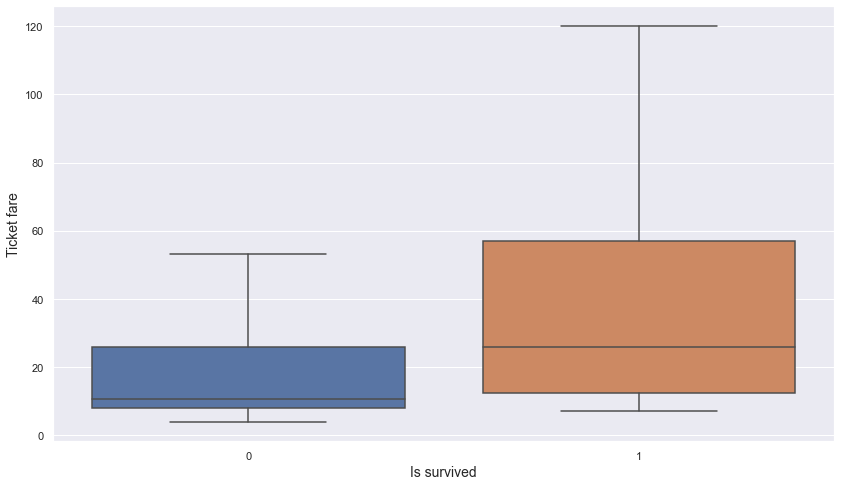

In [44]:
plt.figure(figsize = (14, 8))

sns.boxplot(data = titanic, x = "is_survived", y = "ticket_fare", showfliers = False)
plt.xlabel("Is survived", fontsize = 14)
plt.ylabel("Ticket fare", fontsize = 14)
plt.show()

- It seems that passengers who paid the higher fare may have been more likely to have survived.         
    -> Let's cut the ticket_fare into 3 categories and compare the survival rate of each category. 

In [45]:
titanic['ticket_fare_category'] = pd.qcut(titanic.ticket_fare, 3)
titanic.ticket_fare_category.value_counts()

(8.676, 26.25]                300
(4.010999999999999, 8.676]    297
(26.25, 512.329]              294
Name: ticket_fare_category, dtype: int64

In [46]:
ticket_fare_category_is_survived = pd.pivot_table(index = "ticket_fare_category", columns = "is_survived", aggfunc = len, fill_value = 0, data = titanic[["ticket_fare_category", "is_survived"]])
ticket_fare_category_is_survived = ticket_fare_category_is_survived.reset_index().rename_axis(None, axis = 1)
ticket_fare_category_is_survived["total"] = ticket_fare_category_is_survived[0] + ticket_fare_category_is_survived[1]
ticket_fare_category_is_survived["ratio"] = np.round(ticket_fare_category_is_survived[1] / ticket_fare_category_is_survived.total, 2)
ticket_fare_category_is_survived

,ticket_fare_category,0,1,total,ratio
0,"(4.010999999999999, 8.676]",236,61,297,0.21
1,"(8.676, 26.25]",180,120,300,0.40
2,"(26.25, 512.329]",133,161,294,0.55


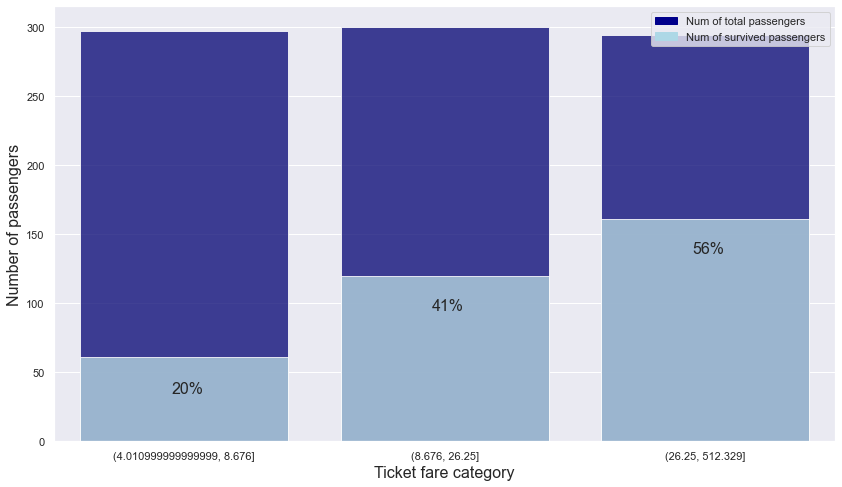

In [47]:
plt.figure(figsize = (14, 8))

# bar graph for total students
color = "darkblue"
ax1 = sns.barplot(x = "ticket_fare_category", y = "total", color = color, alpha = 0.8, \
                  data = ticket_fare_category_is_survived)
top_bar = mpatches.Patch(color = color, label = 'Num of total passengers')

# bar graph for students have research experience
color = "lightblue"
ax2 = sns.barplot(x = "ticket_fare_category", y = 1,  color = color, alpha = 0.8, \
                  data = ticket_fare_category_is_survived)
ax2.set_xlabel("Ticket fare category", fontsize = 16)
ax2.set_ylabel("Number of passengers", fontsize = 16)
low_bar = mpatches.Patch(color = color, label = 'Num of survived passengers')

# ratio
plt.text(s = "20%", x = -0.05, y = 35, fontsize = 16)
plt.text(s = "41%", x = 0.95, y = 95, fontsize = 16)
plt.text(s = "56%", x = 1.95, y = 136, fontsize = 16)

plt.legend(handles=[top_bar, low_bar])
plt.show()

- It can be seen that the category that paid a higher fare showed a higher survival rate.      
    -> Use the ticket_fare_category column.

### cabin_number

In [48]:
titanic["cabin_number"]

0       NaN
1       C85
2       NaN
3      C123
4       NaN
       ... 
886     NaN
887     B42
888     NaN
889    C148
890     NaN
Name: cabin_number, Length: 891, dtype: object

- cabin_number is form of alphabet + number     
    -> Let's divide the alphabet part and make this alphabet as a new column

In [49]:
titanic["cabin_alphabet"] = titanic.cabin_number.str[0]
titanic["cabin_alphabet"] = titanic["cabin_alphabet"].fillna("n")

In [50]:
titanic.cabin_alphabet.value_counts()

n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: cabin_alphabet, dtype: int64

- n means missing values. There are too many missing values in the cabin_alphabet column      
    -> If it is not related with is_survived or p_class, then do not use cabin_number and cabin_alphabet

### cabin_alphabet ~ is_survived | p_class

Let's check relationship between cabin_alphabet and p_class

In [51]:
pt = pd.pivot_table(index = "p_class", columns = "cabin_alphabet", aggfunc = len, fill_value = 0, data = titanic[["p_class", "cabin_alphabet"]])
pt

cabin_alphabet,A,B,C,D,E,F,G,T,n
p_class,,,,,,,,,
1,15,47,59,29,25,0,0,1,40
2,0,0,0,4,4,8,0,0,168
3,0,0,0,0,3,5,4,0,479


- There are too many missing values in passenger class = 2 and passenger class = 3

Let's check relationship between cabin_alphabet and is_survived.

In [52]:
pt = pd.pivot_table(index = "is_survived", columns = "cabin_alphabet", aggfunc = len, fill_value = 0, data = titanic[["is_survived", "cabin_alphabet"]])
pt

cabin_alphabet,A,B,C,D,E,F,G,T,n
is_survived,,,,,,,,,
0,8,12,24,8,8,5,2,1,481
1,7,35,35,25,24,8,2,0,206


- Also, there are too many missing values in both is_survived cases     
    -> Do not use cabin_number and cabin_alphabet

### embark_port

In [53]:
titanic.embark_port.value_counts().reset_index().rename(columns = {"index" : "embark_port", "embark_port" : "count"})

,embark_port,count
0,S,644
1,C,168
2,Q,77


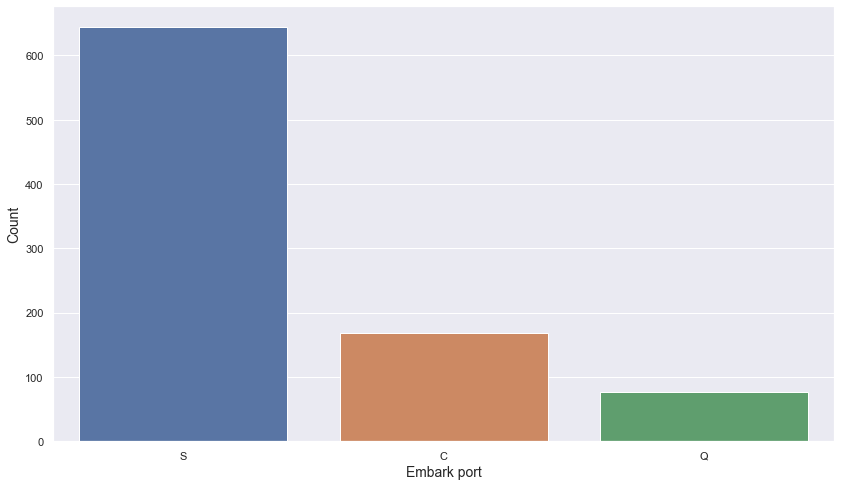

In [54]:
plt.figure(figsize = (14, 8))
sns.barplot(data = titanic.embark_port.value_counts().reset_index().rename(columns = {"index" : "embark_port", "embark_port" : "count"}),
            x = "embark_port",
            y = "count")
plt.xlabel("Embark port", fontsize = 14)
plt.ylabel("Count", fontsize = 14)
plt.show()

- Most passengers boarded from Southampton (S) port
- Least passengers boarded from Queenstown (Q) port     

In [55]:
titanic[titanic.embark_port.isnull()]

,is_survived,p_class,name,sex,age,num_sb_sp,num_pr_ch,ticket_number,ticket_fare,cabin_number,embark_port,ticket_number_alphabet,ticket_number_number,num_cmp,ticket_fare_category,cabin_alphabet
61,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,non,113572,1,"(26.25, 512.329]",B
829,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,non,113572,1,"(26.25, 512.329]",B


- There are only 2 rows where embark_port has a missing value.       
    -> Fill missing value with the most common embarked_pork value: S

In [56]:
titanic["embark_port"] = titanic["embark_port"].fillna("S")

In [57]:
np.sum(titanic.embark_port.isnull())

0

### embark_port ~ p_class

Let's check a relationship between embark_port and p_class

In [58]:
pd.pivot_table(index = "p_class", columns = "embark_port", aggfunc = len, fill_value = 0, data = titanic[titanic.ticket_fare != 0][["p_class", "embark_port"]])

embark_port,C,Q,S
p_class,,,
1,85,2,129
2,17,3,164
3,66,72,353


- Almost every people who boarded from Q was 3 passenger class.            
    -> Since embark_port has some influence in passenger class, let's check the relationship between embark_port and is_survived

### embark_port ~ is_survived

In [59]:
embark_port_is_survived = titanic.groupby(["embark_port","is_survived"]).count().name.unstack().reset_index()
embark_port_is_survived = embark_port_is_survived.rename_axis(None, axis = 1)
embark_port_is_survived["total"] = embark_port_is_survived[0] + embark_port_is_survived[1]
embark_port_is_survived["ratio"] = np.round(embark_port_is_survived[1] / embark_port_is_survived.total, 2)
embark_port_is_survived

,embark_port,0,1,total,ratio
0,C,75,93,168,0.55
1,Q,47,30,77,0.39
2,S,427,219,646,0.34


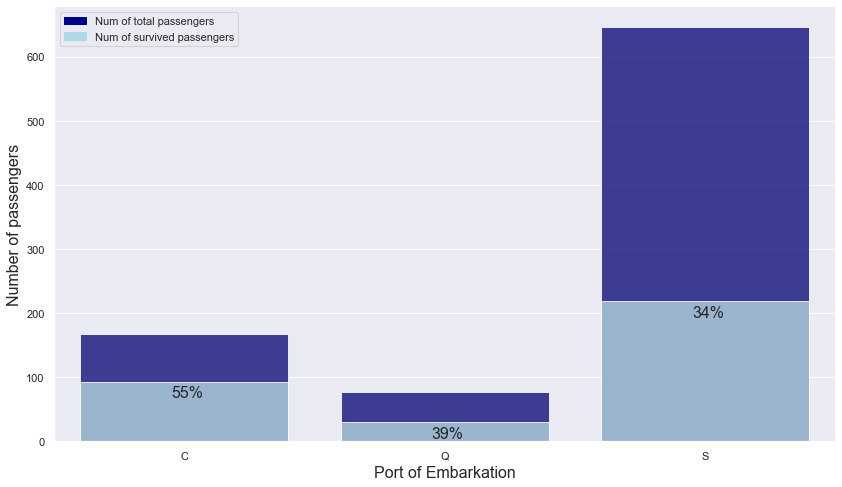

In [60]:
plt.figure(figsize = (14, 8))

# bar graph for total students
color = "darkblue"
ax1 = sns.barplot(x = "embark_port", y = "total", color = color, alpha = 0.8, \
                  data = embark_port_is_survived)
top_bar = mpatches.Patch(color = color, label = 'Num of total passengers')

# bar graph for students have research experience
color = "lightblue"
ax2 = sns.barplot(x = "embark_port", y = 1,  color = color, alpha = 0.8, \
                  data = embark_port_is_survived)
ax2.set_xlabel("Port of Embarkation", fontsize = 16)
ax2.set_ylabel("Number of passengers", fontsize = 16)
low_bar = mpatches.Patch(color = color, label = 'Num of survived passengers')

# ratio
plt.text(s = "55%", x = -0.05, y = 68, fontsize = 16)
plt.text(s = "39%", x = 0.95, y = 5, fontsize = 16)
plt.text(s = "34%", x = 1.95, y = 194, fontsize = 16)

plt.legend(handles=[top_bar, low_bar])
plt.show()

- People boarded from Q and S have similar survival rates: about 39% and 34%.      
- People boarded from C have a higher survival rate than people boarded from other ports.        
    -> Use embark_port column

## 1.1. Person related columns: name, sex, age

### name

In [61]:
np.sum(titanic.name.isnull())

0

- There is no missing value in the name column.

In [62]:
len(titanic.name.unique())

891

- All 891 rows have differnt name values.      
    -> Let's think about more general features from name.

In [63]:
titanic.name.head(10)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: name, dtype: object

- We can see that names are a form of Last name + title + first name.      
    -> Let's extract the title from the name

In [64]:
titanic["name_title"] = titanic.name.str.extract(' ([A-Za-z]+)\.', expand=False)
titanic.name_title.value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: name_title, dtype: int64

- There are too many uncommon titles that appear only a few times.     
    -> Let's replace uncommon titles.

In [65]:
titanic['name_title'] = titanic['name_title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', \
                                                       'Rev', 'Sir', 'Jonkheer', 'Dona'], 'uncommon')

titanic['name_title'] = titanic['name_title'].replace('Mlle', 'Miss')
titanic['name_title'] = titanic['name_title'].replace('Ms', 'Miss')
titanic['name_title'] = titanic['name_title'].replace('Mme', 'Mrs')

In [66]:
titanic.name_title.value_counts()

Mr          517
Miss        185
Mrs         126
Master       40
uncommon     23
Name: name_title, dtype: int64

### name_title ~ is_survived

Let's check the relationship between name_title and is_survived.

In [67]:
name_title_is_survived = titanic.groupby(["name_title","is_survived"]).count().name.unstack().reset_index()
name_title_is_survived = name_title_is_survived.rename_axis(None, axis = 1)
name_title_is_survived["total"] = name_title_is_survived[0] + name_title_is_survived[1]
name_title_is_survived["ratio"] = np.round(name_title_is_survived[1] / name_title_is_survived.total, 2)
name_title_is_survived

,name_title,0,1,total,ratio
0,Master,17,23,40,0.57
1,Miss,55,130,185,0.70
2,Mr,436,81,517,0.16
3,Mrs,26,100,126,0.79
4,uncommon,15,8,23,0.35


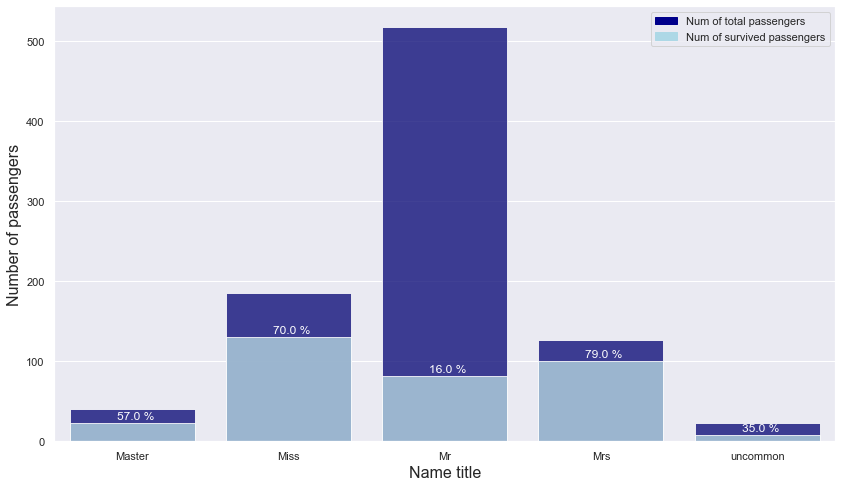

In [68]:
plt.figure(figsize = (14, 8))

# bar graph for total students
color = "darkblue"
ax1 = sns.barplot(x = "name_title", y = "total", color = color, alpha = 0.8, \
                  data = name_title_is_survived)
top_bar = mpatches.Patch(color = color, label = 'Num of total passengers')

# bar graph for students have research experience
color = "lightblue"
ax2 = sns.barplot(x = "name_title", y = 1,  color = color, alpha = 0.8, \
                  data = name_title_is_survived)
ax2.set_xlabel("Name title", fontsize = 16)
ax2.set_ylabel("Number of passengers", fontsize = 16)
low_bar = mpatches.Patch(color = color, label = 'Num of survived passengers')

# ratio
for n in name_title_is_survived.index:
    plt.text(s = f"{np.round(name_title_is_survived.loc[n].ratio * 100, 2)} %", x = n - 0.1, y = name_title_is_survived.loc[n][1] + 5, color = "white")
 
    
plt.legend(handles=[top_bar, low_bar])
plt.show()

- Passengers with Miss and Mrs titles showed an overwhelming survival rate of over 70%     
    -> Use name_title instead of name

### sex

In [69]:
np.sum(titanic.sex.isnull())

0

- There is no missing value in the sex column.

In [70]:
titanic.sex.value_counts()

male      577
female    314
Name: sex, dtype: int64

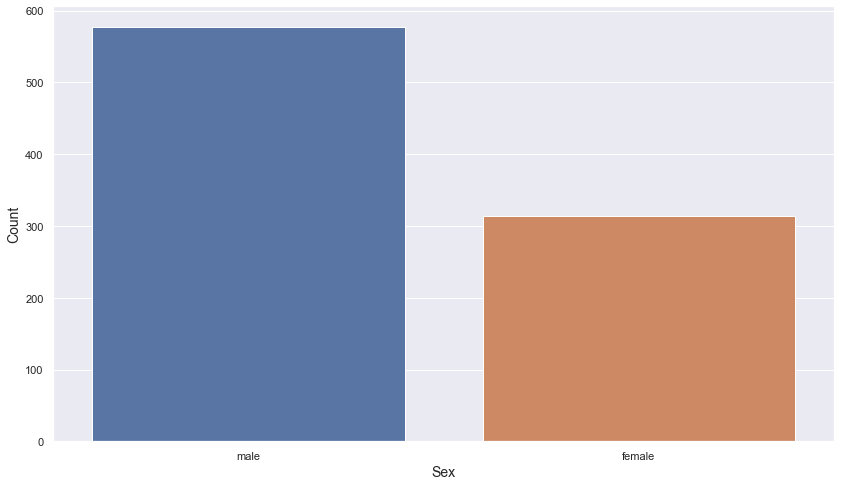

In [71]:
plt.figure(figsize = (14, 8))
sns.barplot(data = titanic.sex.value_counts().reset_index().rename(columns = {"index" : "sex", "sex" : "count"}),
            x = "sex",
            y = "count")
plt.xlabel("Sex", fontsize = 14)
plt.ylabel("Count", fontsize = 14)
plt.show()

- There are about twice as many male passengers as female passengers.

### sex ~ p_class

Let's check the relationship between sex and p_class.

In [72]:
sex_p_class = pd.pivot_table(index = "p_class", columns = "sex", aggfunc = len, fill_value = 0, data = titanic[["p_class", "sex"]])
sex_p_class = sex_p_class.reset_index().rename_axis(None, axis = 1)
sex_p_class["total"] = sex_p_class["female"] + sex_p_class["male"]
sex_p_class["ratio"] = np.round(sex_p_class["male"] / sex_p_class.total, 2)
sex_p_class

,p_class,female,male,total,ratio
0,1,94,122,216,0.56
1,2,76,108,184,0.59
2,3,144,347,491,0.71


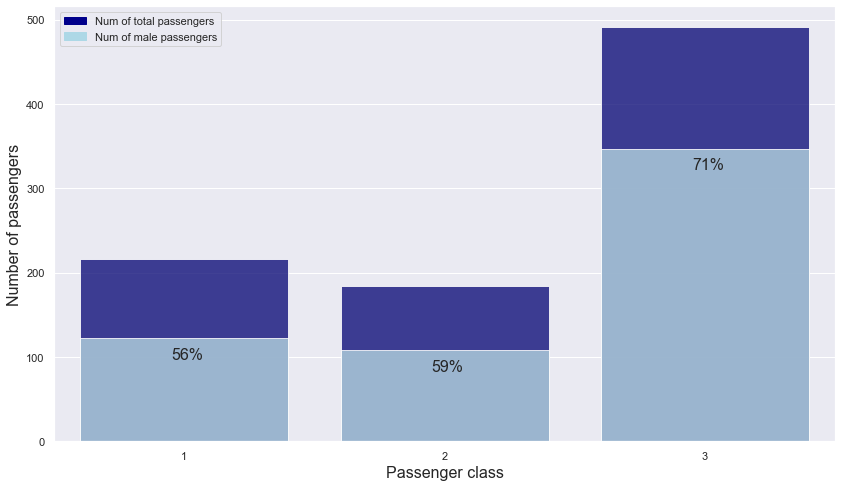

In [73]:
plt.figure(figsize = (14, 8))

# bar graph for total students
color = "darkblue"
ax1 = sns.barplot(x = "p_class", y = "total", color = color, alpha = 0.8, \
                  data = sex_p_class)
top_bar = mpatches.Patch(color = color, label = 'Num of total passengers')

# bar graph for students have research experience
color = "lightblue"
ax2 = sns.barplot(x = "p_class", y = "male",  color = color, alpha = 0.8, \
                  data = sex_p_class)
ax2.set_xlabel("Passenger class", fontsize = 16)
ax2.set_ylabel("Number of passengers", fontsize = 16)
low_bar = mpatches.Patch(color = color, label = 'Num of male passengers')

# ratio
plt.text(s = "56%", x = -0.05, y = 97, fontsize = 16)
plt.text(s = "59%", x = 0.95, y = 83, fontsize = 16)
plt.text(s = "71%", x = 1.95, y = 322, fontsize = 16)

plt.legend(handles=[top_bar, low_bar])
plt.show()

- Passengers from classes 1 and 2 have a similar male rate: about 56% and 59%    
- Passengers from class 3 have a higher male rate than passengers from other classes.

### sex ~ is_survived

In [74]:
sex_is_survived = pd.pivot_table(index = "sex", columns = "is_survived", aggfunc = len, fill_value = 0, data = titanic[["is_survived", "sex"]])
sex_is_survived = sex_is_survived.reset_index().rename_axis(None, axis = 1)
sex_is_survived["total"] = sex_is_survived[0] + sex_is_survived[1]
sex_is_survived["ratio"] = np.round(sex_is_survived[1] / sex_is_survived.total, 2)
sex_is_survived

,sex,0,1,total,ratio
0,female,81,233,314,0.74
1,male,468,109,577,0.19


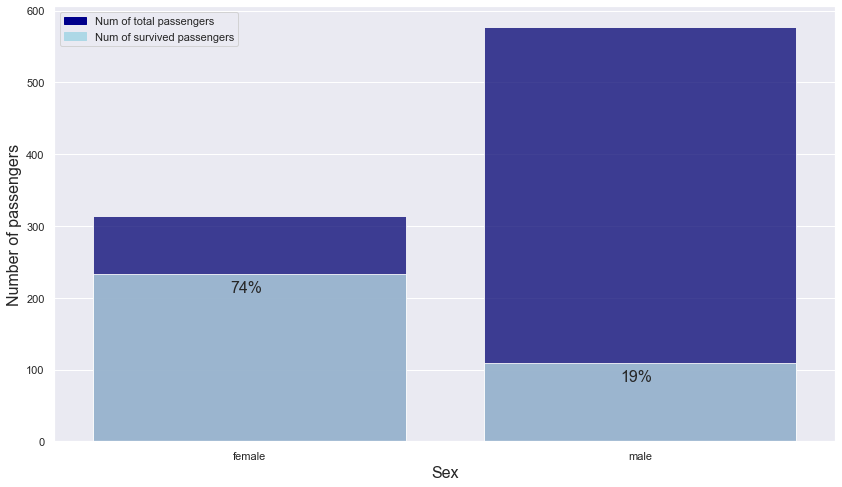

In [75]:
plt.figure(figsize = (14, 8))

# bar graph for total students
color = "darkblue"
ax1 = sns.barplot(x = "sex", y = "total", color = color, alpha = 0.8, \
                  data = sex_is_survived)
top_bar = mpatches.Patch(color = color, label = 'Num of total passengers')

# bar graph for students have research experience
color = "lightblue"
ax2 = sns.barplot(x = "sex", y = 1,  color = color, alpha = 0.8, \
                  data = sex_is_survived)
ax2.set_xlabel("Sex", fontsize = 16)
ax2.set_ylabel("Number of passengers", fontsize = 16)
low_bar = mpatches.Patch(color = color, label = 'Num of survived passengers')

# ratio
plt.text(s = "74%", x = -0.05, y = 208, fontsize = 16)
plt.text(s = "19%", x = 0.95, y = 84, fontsize = 16)

plt.legend(handles=[top_bar, low_bar])
plt.show()

- We can see that sex had a huge impact on survival. Only 19% of the male passengers survived, while 74% of the female passengers survived.     
    -> Use sex column

### age

In [76]:
np.sum(titanic.age.isnull())

177

- There are 177 missing values in the age column      
    -> Need to think about how to impute missing values.

In [77]:
titanic.age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: age, dtype: float64

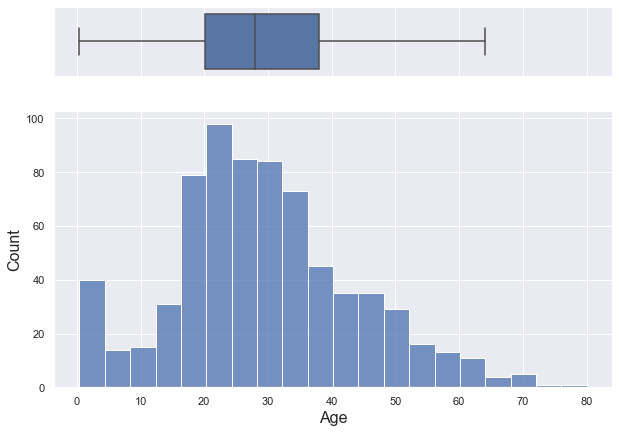

In [78]:
fig, (ax_box, ax_hist) = plt.subplots(2, sharex = True, gridspec_kw = {"height_ratios": (.2, .8)}, figsize = (10, 7))

sns.boxplot(x = titanic.age, ax = ax_box, showfliers = False)
sns.histplot(x = titanic.age, ax = ax_hist)

plt.xlabel("Age", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
ax_box.set_xlabel("")

plt.show()

- age shows a slightly bell-shaped distribution 

For further analysis, let's make new column of age category.

In [79]:
import math

In [80]:
math.log(0.04 * 0.05 * 0.06) * -2

18.056037630364457

In [81]:
math.log(0.6 * 0.25 * 0.01) * -2

13.004580341747944

In [82]:
titanic["age_category"] = pd.cut(titanic.age, 10)
titanic.age_category.value_counts()

(16.336, 24.294]    177
(24.294, 32.252]    169
(32.252, 40.21]     118
(40.21, 48.168]      70
(0.34, 8.378]        54
(8.378, 16.336]      46
(48.168, 56.126]     45
(56.126, 64.084]     24
(64.084, 72.042]      9
(72.042, 80.0]        2
Name: age_category, dtype: int64

### p_class ~ age | age_category

Let's check the relationship between p_class and age.

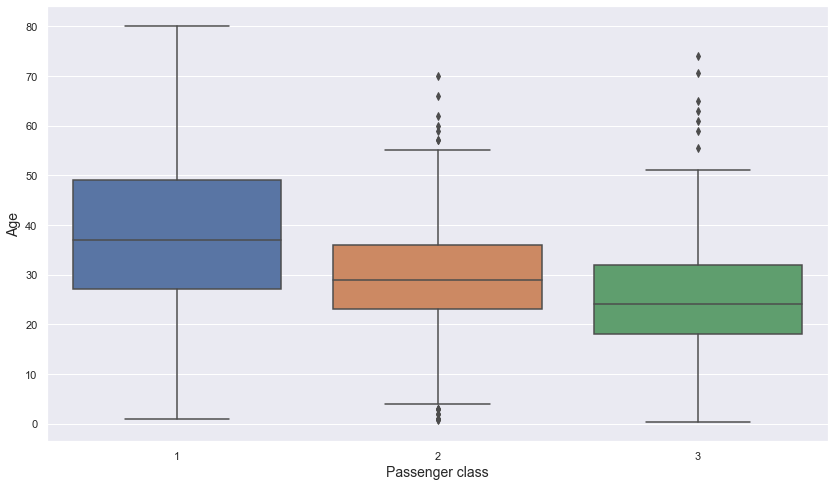

In [83]:
plt.figure(figsize = (14, 8))

sns.boxplot(data = titanic, x = "p_class", y = "age")
plt.xlabel("Passenger class", fontsize = 14)
plt.ylabel("Age", fontsize = 14)
plt.show()

- The better the class, the older the passengers in it tend to be.

Let's see the relationship of passenger class and age by age category.

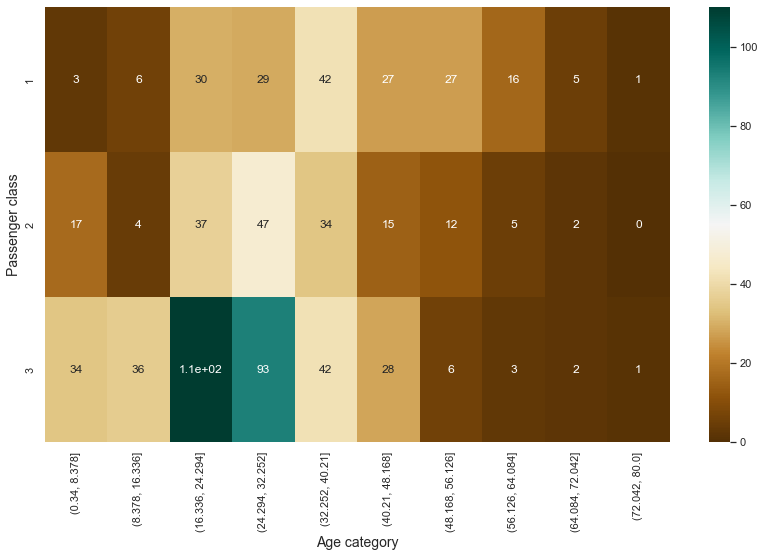

In [84]:
pt = pd.pivot_table(index = "p_class", columns = "age_category", aggfunc = len, fill_value = 0, data = titanic[["p_class", "age_category"]])

plt.figure(figsize = (14, 8))
sns.heatmap(pt, annot = True, cmap = 'BrBG');
plt.xlabel("Age category", fontsize = 14)
plt.ylabel("Passenger class", fontsize = 14)
plt.show()


- In particular, in class 3, it can be seen that the proportion of young people is high.
- In classes 1 and 2, the proportion of passengers in the middle age group is high.     
    -> There seems to be some relationship between age and class. So, let's look at the relationship between age and survival rate.

### is_survived ~ age | age_category

Let's check the relationship between is_survived and age.

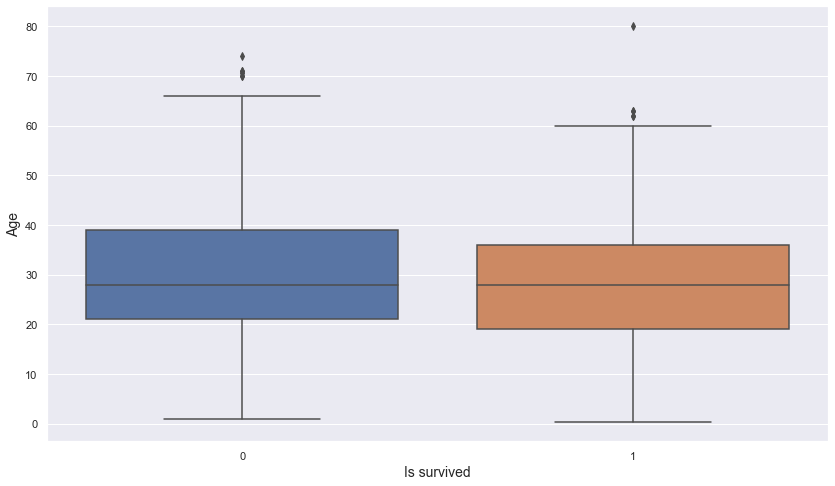

In [85]:
plt.figure(figsize = (14, 8))

sns.boxplot(data = titanic, x = "is_survived", y = "age")
plt.xlabel("Is survived", fontsize = 14)
plt.ylabel("Age", fontsize = 14)
plt.show()

- There appears to be no difference in the distribution of age between the survived and non-survived groups.

In [86]:
age_category_is_survived = pd.pivot_table(index = "age_category", columns = "is_survived", aggfunc = len, fill_value = 0, data = titanic[["is_survived", "age_category"]])
age_category_is_survived = age_category_is_survived.reset_index().rename_axis(None, axis = 1)
age_category_is_survived["total"] = age_category_is_survived[0] + age_category_is_survived[1]
age_category_is_survived["ratio"] = np.round(age_category_is_survived[1] / age_category_is_survived.total, 2)
age_category_is_survived

,age_category,0,1,total,ratio
0,"(0.34, 8.378]",18,36,54,0.67
1,"(8.378, 16.336]",27,19,46,0.41
2,"(16.336, 24.294]",114,63,177,0.36
3,"(24.294, 32.252]",104,65,169,0.38
4,"(32.252, 40.21]",66,52,118,0.44
5,"(40.21, 48.168]",46,24,70,0.34
6,"(48.168, 56.126]",24,21,45,0.47
7,"(56.126, 64.084]",15,9,24,0.38
8,"(64.084, 72.042]",9,0,9,0.00
9,"(72.042, 80.0]",1,1,2,0.50


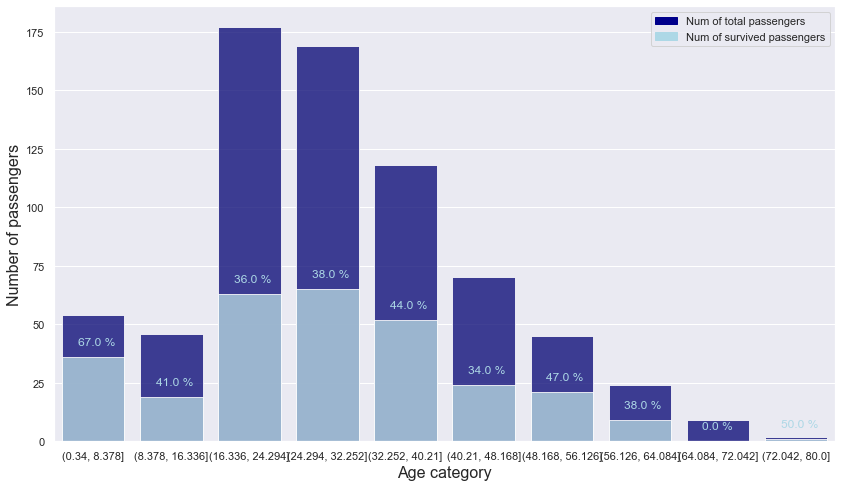

In [87]:
plt.figure(figsize = (14, 8))

# bar graph for total students
color = "darkblue"
ax1 = sns.barplot(x = "age_category", y = "total", color = color, alpha = 0.8, \
                  data = age_category_is_survived)
top_bar = mpatches.Patch(color = color, label = 'Num of total passengers')

# bar graph for students have research experience
color = "lightblue"
ax2 = sns.barplot(x = "age_category", y = 1,  color = color, alpha = 0.8, \
                  data = age_category_is_survived)
ax2.set_xlabel("Age category", fontsize = 16)
ax2.set_ylabel("Number of passengers", fontsize = 16)
low_bar = mpatches.Patch(color = color, label = 'Num of survived passengers')

# ratio
for n in age_category_is_survived.index:
    plt.text(s = f"{age_category_is_survived.loc[n].ratio * 100} %", x = n - 0.2, y = age_category_is_survived.loc[n][1] + 5, color = "lightblue")
 
    
plt.legend(handles=[top_bar, low_bar])
plt.show()

- It can be seen that the survival rate decreases with increasing age and then rises again.                
    -> Use age category and age. Then since age has 177 missing values, we have to consider how to impute missing values in age.

### age ~ sex

Let's check the relationship between age and sex.

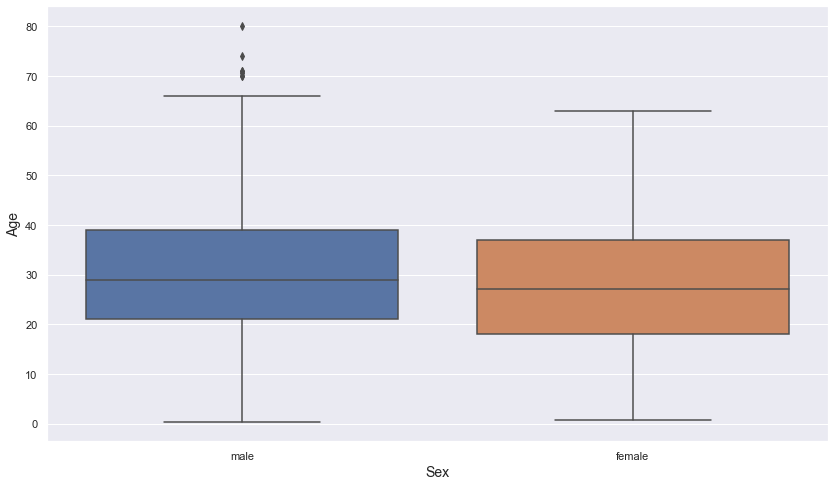

In [88]:
plt.figure(figsize = (14, 8))

sns.boxplot(data = titanic, x = "sex", y = "age")
plt.xlabel("Sex", fontsize = 14)
plt.ylabel("Age", fontsize = 14)
plt.show()

- There appears to be no difference in the distribution of age between the male and female groups.

Let's check the distribution in more detail using age category.

In [89]:
age_sex = titanic.groupby(["age_category"]).sex.value_counts().unstack().fillna(0)
age_sex = age_sex.reset_index().rename_axis(None, axis = 1)
age_sex

,age_category,female,male
0,"(0.34, 8.378]",26.0,28.0
1,"(8.378, 16.336]",23.0,23.0
2,"(16.336, 24.294]",68.0,109.0
3,"(24.294, 32.252]",52.0,117.0
4,"(32.252, 40.21]",44.0,74.0
5,"(40.21, 48.168]",24.0,46.0
6,"(48.168, 56.126]",16.0,29.0
7,"(56.126, 64.084]",8.0,16.0
8,"(64.084, 72.042]",0.0,9.0
9,"(72.042, 80.0]",0.0,2.0


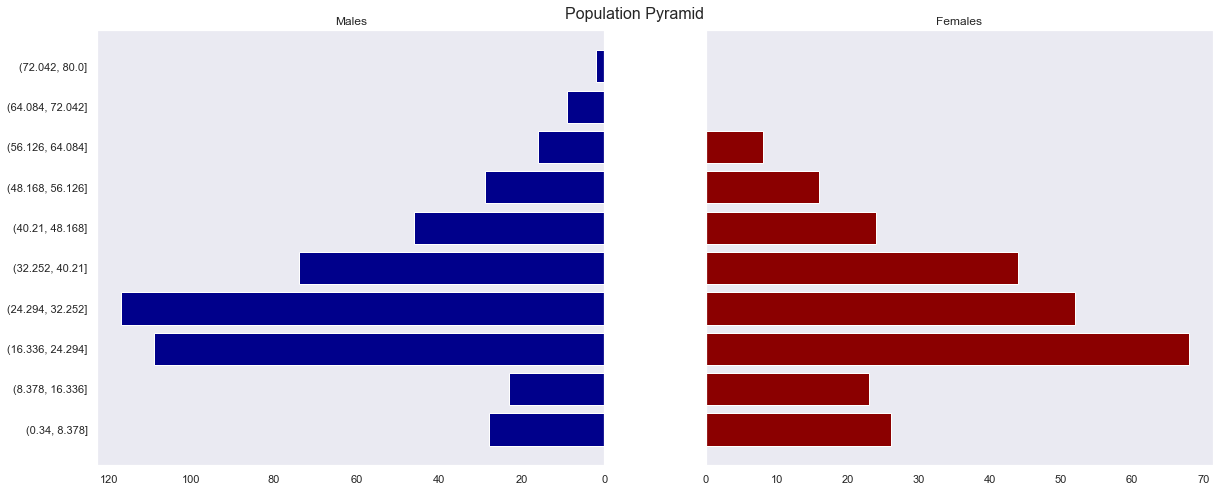

In [90]:
#define plot parameters
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(20, 8))

#specify background color and plot title
#fig.patch.set_facecolor('xkcd:light grey')
plt.figtext(.5,.9,"Population Pyramid ", fontsize=16, ha='center')
    
#define male and female bars
axes[0].barh(range(0, len(age_sex)), age_sex.male, align='center', color='darkblue')
axes[0].set(title='Males')
axes[1].barh(range(0, len(age_sex)), age_sex.female, align='center', color='darkred')
axes[1].set(title='Females')

#adjust grid parameters and specify labels for y-axis
axes[1].grid()
axes[0].set(yticks = range(0, len(age_sex)), yticklabels = age_sex['age_category'])
axes[0].invert_xaxis()
axes[0].grid()

#display plot
plt.show()

- It can be seen that there are typical demographic distributions, with very few passengers in the older and young group and a large number of passengers in the middle-aged group.     
    -> Let's check survival rate by sex and age_category.

### sex ~ age ~ is_survived

In [91]:
male_age_sex = pd.DataFrame(age_sex.age_category.unique(), columns = ["age_category"])

male_age_sex = male_age_sex.merge(pd.pivot_table(index = "age_category", columns = "is_survived", aggfunc = len, fill_value = 0, 
                                                 data = titanic[titanic.sex == "male"][["is_survived", "age_category"]]) \
                                  .reset_index().rename_axis(None, axis = 1),
                                  on = "age_category", how = "left")
male_age_sex["total"] = male_age_sex[0] + male_age_sex[1]
male_age_sex["ratio"] = np.round(male_age_sex[1] / male_age_sex.total, 2)
male_age_sex[[0, 1, "total", "ratio"]] = male_age_sex[[0, 1, "total", "ratio"]].fillna(0)
male_age_sex

,age_category,0,1,total,ratio
0,"(0.34, 8.378]",11,17,28,0.61
1,"(8.378, 16.336]",18,5,23,0.22
2,"(16.336, 24.294]",98,11,109,0.10
3,"(24.294, 32.252]",88,29,117,0.25
4,"(32.252, 40.21]",61,13,74,0.18
5,"(40.21, 48.168]",37,9,46,0.20
6,"(48.168, 56.126]",23,6,29,0.21
7,"(56.126, 64.084]",14,2,16,0.12
8,"(64.084, 72.042]",9,0,9,0.00
9,"(72.042, 80.0]",1,1,2,0.50


In [92]:
female_age_sex = pd.DataFrame(age_sex.age_category.unique(), columns = ["age_category"])

female_age_sex = female_age_sex.merge(pd.pivot_table(index = "age_category", columns = "is_survived", aggfunc = len, fill_value = 0, 
                                                     data = titanic[titanic.sex == "female"][["is_survived", "age_category"]]) \
                                      .reset_index().rename_axis(None, axis = 1),
                                      on = "age_category", how = "left")
female_age_sex["total"] = female_age_sex[0] + female_age_sex[1]
female_age_sex["ratio"] = np.round(female_age_sex[1] / female_age_sex.total, 2)
female_age_sex[[0, 1, "total", "ratio"]] = female_age_sex[[0, 1, "total", "ratio"]].fillna(0)
female_age_sex

,age_category,0,1,total,ratio
0,"(0.34, 8.378]",7.0,19.0,26.0,0.73
1,"(8.378, 16.336]",9.0,14.0,23.0,0.61
2,"(16.336, 24.294]",16.0,52.0,68.0,0.76
3,"(24.294, 32.252]",16.0,36.0,52.0,0.69
4,"(32.252, 40.21]",5.0,39.0,44.0,0.89
5,"(40.21, 48.168]",9.0,15.0,24.0,0.62
6,"(48.168, 56.126]",1.0,15.0,16.0,0.94
7,"(56.126, 64.084]",1.0,7.0,8.0,0.88
8,"(64.084, 72.042]",0.0,0.0,0.0,0.00
9,"(72.042, 80.0]",0.0,0.0,0.0,0.00


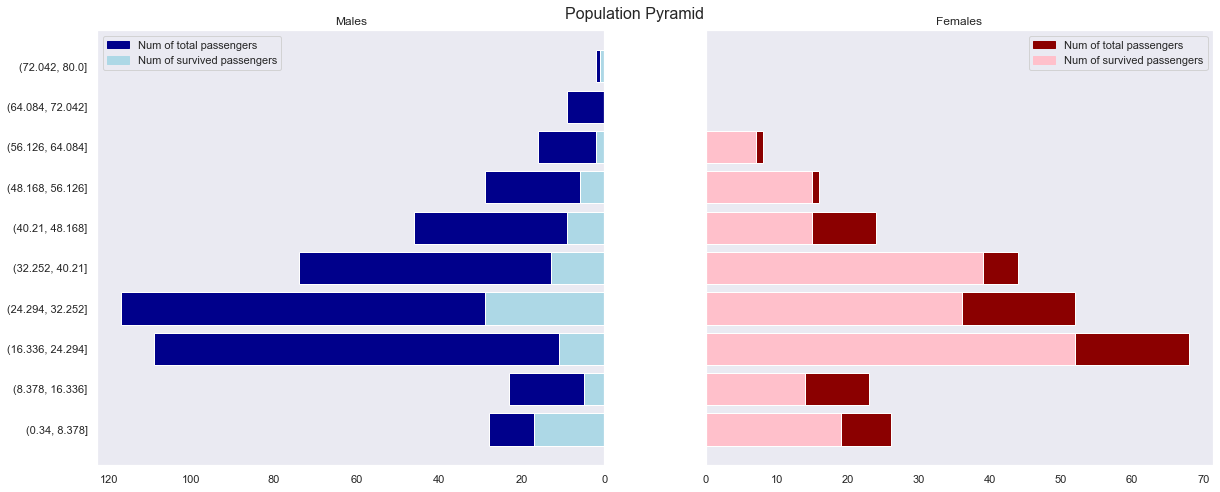

In [93]:
#define plot parameters
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(20, 8))

#specify background color and plot title
#fig.patch.set_facecolor('xkcd:light grey')
plt.figtext(.5,.9,"Population Pyramid ", fontsize=16, ha='center')
    
#define male and female bars
axes[0].barh(range(0, len(age_sex)), male_age_sex.total, align='center', color='darkblue')
axes[0].barh(range(0, len(age_sex)), male_age_sex[1], align='center', color='lightblue')
axes[0].set(title='Males')
top_bar = mpatches.Patch(color = "darkblue", label = 'Num of total passengers')
low_bar = mpatches.Patch(color = "lightblue", label = 'Num of survived passengers')
axes[0].legend(handles = [top_bar, low_bar])


axes[1].barh(range(0, len(age_sex)), female_age_sex.total, align='center', color='darkred')
axes[1].barh(range(0, len(age_sex)), female_age_sex[1], align='center', color='pink')
axes[1].set(title='Females')
top_bar = mpatches.Patch(color = "darkred", label = 'Num of total passengers')
low_bar = mpatches.Patch(color = "pink", label = 'Num of survived passengers')
axes[1].legend(handles = [top_bar, low_bar])

#adjust grid parameters and specify labels for y-axis
axes[1].grid()
axes[0].set(yticks = range(0, len(age_sex)), yticklabels = age_sex['age_category'])
axes[0].invert_xaxis()
axes[0].grid()

#display plot
plt.show()

- In all age groups, it can be seen that the survival rate of women is overwhelmingly higher than that of men.
- Children under the age of 8 have a particularly high survival rate for both male and female.

### name_title ~ age

Let's check the relationship between name_title and age.

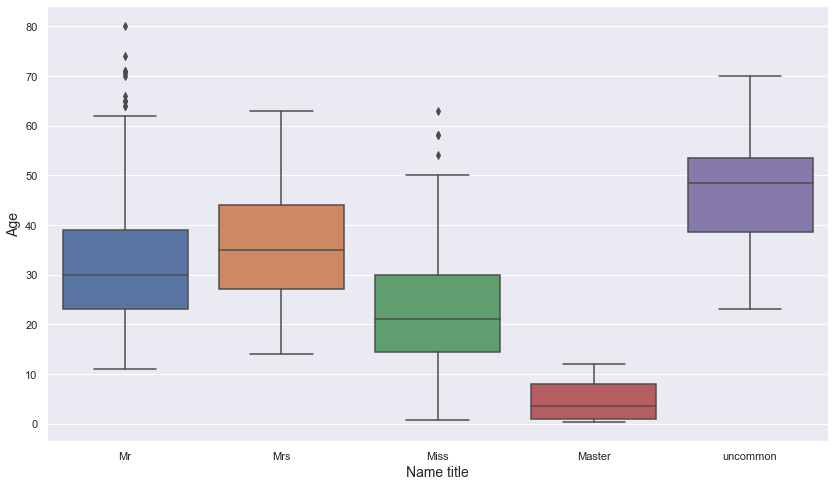

In [94]:
plt.figure(figsize = (14, 8))

sns.boxplot(data = titanic, x = "name_title", y = "age")
plt.xlabel("Name title", fontsize = 14)
plt.ylabel("Age", fontsize = 14)
plt.show()

- It can be seen that there is a meaningful difference in the age distribution of name titles.         

In [95]:
titanic[titanic.name_title == "Master"][["p_class", "name_title", "sex", "age", "age_category", "num_sb_sp", "num_pr_ch", "num_cmp"]].sort_values("age")

,p_class,name_title,sex,age,age_category,num_sb_sp,num_pr_ch,num_cmp
803,3,Master,male,0.42,"(0.34, 8.378]",0,1,1
755,2,Master,male,0.67,"(0.34, 8.378]",1,1,2
831,2,Master,male,0.83,"(0.34, 8.378]",1,1,2
78,2,Master,male,0.83,"(0.34, 8.378]",0,2,2
305,1,Master,male,0.92,"(0.34, 8.378]",1,2,3
827,2,Master,male,1.00,"(0.34, 8.378]",0,2,2
164,3,Master,male,1.00,"(0.34, 8.378]",4,1,5
788,3,Master,male,1.00,"(0.34, 8.378]",1,2,3
183,2,Master,male,1.00,"(0.34, 8.378]",2,1,3
386,3,Master,male,1.00,"(0.34, 8.378]",5,2,7


- Passengers who have "Master" as their name_title are all under 12 ages.         
    -> Fill missing values with name_title "Master" with a mean age of passengers with "Master" name title

In [96]:
titanic.loc[(titanic.name_title == "Master") & (titanic.age.isnull()), "age"] = np.mean(titanic[titanic.name_title == "Master"].age)

In [97]:
titanic[(titanic.name_title == "Master") & (titanic.age.isnull())]

,is_survived,p_class,name,sex,age,num_sb_sp,num_pr_ch,ticket_number,ticket_fare,cabin_number,embark_port,ticket_number_alphabet,ticket_number_number,num_cmp,ticket_fare_category,cabin_alphabet,name_title,age_category


In [98]:
titanic[(titanic.age < 15) & (titanic.sex == "female")][["p_class", "name_title", "sex", "age", "age_category", "num_sb_sp", "num_pr_ch", "num_cmp"]].sort_values("age")

,p_class,name_title,sex,age,age_category,num_sb_sp,num_pr_ch,num_cmp
644,3,Miss,female,0.75,"(0.34, 8.378]",2,1,3
469,3,Miss,female,0.75,"(0.34, 8.378]",2,1,3
172,3,Miss,female,1.00,"(0.34, 8.378]",1,1,2
381,3,Miss,female,1.00,"(0.34, 8.378]",0,2,2
479,3,Miss,female,2.00,"(0.34, 8.378]",0,1,1
642,3,Miss,female,2.00,"(0.34, 8.378]",3,2,5
297,1,Miss,female,2.00,"(0.34, 8.378]",1,2,3
530,2,Miss,female,2.00,"(0.34, 8.378]",1,1,2
205,3,Miss,female,2.00,"(0.34, 8.378]",0,1,1
119,3,Miss,female,2.00,"(0.34, 8.378]",4,2,6


- Almost every female passenger under 15 has the name title "Miss". But the age range of passengers with "Miss" is too broad.       
    -> let's consider linear regression to impute other missing values in age.

First, we have to convert customized categorical variables (ticket_fare_category) to numerical variables.

In [99]:
# Make orderic variables for ticket_fare_category column

titanic.loc[titanic['ticket_fare'] <= 8.676, 'ticket_fare_category_order'] = 1
titanic.loc[(titanic['ticket_fare'] > 8.676) & (titanic['ticket_fare'] <= 26.25), 'ticket_fare_category_order'] = 2
titanic.loc[titanic['ticket_fare'] > 26.25, 'ticket_fare_category_order'] = 3

In [100]:
titanic.ticket_fare_category.value_counts()

(8.676, 26.25]                300
(4.010999999999999, 8.676]    297
(26.25, 512.329]              294
Name: ticket_fare_category, dtype: int64

In [101]:
titanic.ticket_fare_category_order.value_counts()

2.0    300
1.0    297
3.0    294
Name: ticket_fare_category_order, dtype: int64

In [102]:
X = titanic[titanic.age.isnull() == False][["p_class", "num_sb_sp", "num_pr_ch", "ticket_fare", "num_cmp", "ticket_fare_category_order", "sex", "embark_port", "name_title"]]
y = titanic[titanic.age.isnull() == False].age

In [103]:
num_features = ["p_class", "num_sb_sp", "num_pr_ch", "ticket_fare", "num_cmp", "ticket_fare_category_order"]
nonnum_features = ["sex", "embark_port", "name_title"]

In [104]:
full_pipeline = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("nonnum", OneHotEncoder(), nonnum_features),
])

In [105]:
X_prep = full_pipeline.fit_transform(X)
X_prep

array([[ 0.9065961 ,  0.48553535, -0.51099538, ...,  1.        ,
         0.        ,  0.        ],
       [-1.48215986,  0.48553535, -0.51099538, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.9065961 , -0.54282565, -0.51099538, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.48215986, -0.54282565, -0.51099538, ...,  0.        ,
         0.        ,  0.        ],
       [-1.48215986, -0.54282565, -0.51099538, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.9065961 , -0.54282565, -0.51099538, ...,  1.        ,
         0.        ,  0.        ]])

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X_prep, y, test_size = 0.1, random_state = 42)

In [107]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((646, 16), (72, 16), (646,), (72,))

In [108]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [109]:
result = cross_validate(lm, X_train, y_train, scoring = "neg_root_mean_squared_error", cv = 5)

In [110]:
-np.mean(result["test_score"]), np.std(result["test_score"])

(11.290133827852916, 0.5883957467368258)

- RMSE in the test set is 11. Since the age has values between 0 and 80, and RMSE gives us an idea of the average distance between the observed data values and the predicted data values, RMSE 11 shows our model is pretty good.      
    -> Then let's compare the result with predicting age with the median value of each name_title.

In [111]:
test_prediction = lm.predict(X_test)

test_mse = mean_squared_error(y_test, test_prediction)
test_rmse = np.sqrt(test_mse)

In [112]:
test_rmse

11.065128385616424

In [113]:
y_test.reset_index()

,index,age
0,148,36.5
1,406,51.0
2,53,29.0
3,796,49.0
4,646,19.0
...,...,...
67,352,15.0
68,743,24.0
69,829,62.0
70,536,45.0


In [114]:
pd.DataFrame(test_prediction.reshape(-1))

,0
0,33.711484
1,28.799848
2,35.226230
3,42.334043
4,28.799088
...,...
67,25.547320
68,27.214570
69,42.273286
70,49.972924


In [115]:
predict_result = pd.concat([y_test.reset_index(), pd.DataFrame(test_prediction.reshape(-1))], axis = 1) \
                 .rename({0 : "predict_by_lm"}, axis = 1)

In [116]:
predict_result["name_title"] = titanic.loc[predict_result["index"]].name_title.values

In [117]:
predict_result = predict_result.merge(titanic.groupby("name_title").age.median().reset_index().rename(columns = {"age" : "predict_by_medain_name_title"}), 
                                      on = "name_title", how = "left")
predict_result

,index,age,predict_by_lm,name_title,predict_by_medain_name_title
0,148,36.5,33.711484,Mr,30.0
1,406,51.0,28.799848,Mr,30.0
2,53,29.0,35.226230,Mrs,35.0
3,796,49.0,42.334043,uncommon,48.5
4,646,19.0,28.799088,Mr,30.0
...,...,...,...,...,...
67,352,15.0,25.547320,Mr,30.0
68,743,24.0,27.214570,Mr,30.0
69,829,62.0,42.273286,Mrs,35.0
70,536,45.0,49.972924,uncommon,48.5


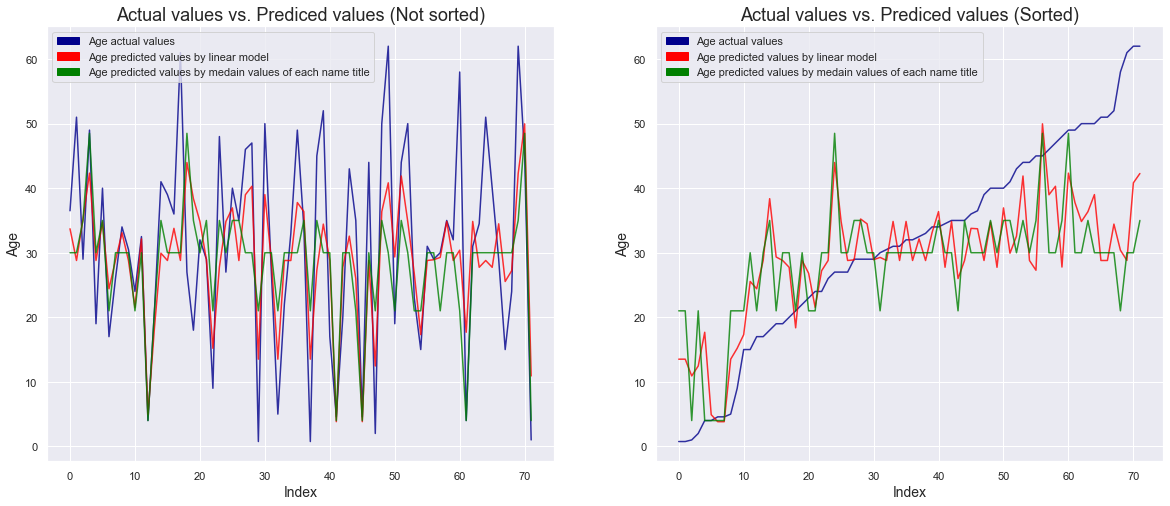

In [118]:
fig, ax = plt.subplots(1, 2, figsize = (20, 8))
top_bar = mpatches.Patch(color = "darkblue", label = 'Age actual values')
middle_bar = mpatches.Patch(color = "red", label = 'Age predicted values by linear model')
low_bar = mpatches.Patch(color = "green", label = 'Age predicted values by medain values of each name title')

sns.lineplot(y = predict_result.age, x = predict_result.index, ax = ax[0], color = "darkblue", alpha = 0.8)
sns.lineplot(y = predict_result.predict_by_lm, x = predict_result.index, ax = ax[0], color = "red", alpha = 0.8)
sns.lineplot(y = predict_result.predict_by_medain_name_title, x = predict_result.index, ax = ax[0], color = "green", alpha = 0.8)
ax[0].set_xlabel("Index", fontsize = 14)
ax[0].set_ylabel("Age", fontsize = 14)
ax[0].set_title("Actual values vs. Prediced values (Not sorted)", fontsize = 18)
ax[0].legend(handles=[top_bar, middle_bar, low_bar])

sns.lineplot(y = predict_result.sort_values("age").age, x = predict_result.index, ax = ax[1], color = "darkblue", alpha = 0.8)
sns.lineplot(y = predict_result.sort_values("age").predict_by_lm, x = predict_result.index, ax = ax[1], color = "red", alpha = 0.8)
sns.lineplot(y = predict_result.sort_values("age").predict_by_medain_name_title, x = predict_result.index, ax = ax[1], color = "green", alpha = 0.8)
ax[1].set_xlabel("Index", fontsize = 14)
ax[1].set_ylabel("Age", fontsize = 14)
ax[1].set_title("Actual values vs. Prediced values (Sorted)", fontsize = 18)
ax[1].legend(handles=[top_bar, middle_bar, low_bar])

plt.show()

- Even if we predict with the median value of each title, some accurate prediction is possible, but we can confirm that the prediction using a linear model is more accurate.
Looking at the graph on the right where age is sorted, it can be seen that the accuracy of the linear model is better, especially in the age groups of children and the elderly, which have a great influence on the survival rate.       
    -> Let's impute missing values in age with the linear model

In [119]:
X_missing_age = titanic[titanic.age.isnull()][["p_class", "num_sb_sp", "num_pr_ch", "ticket_fare", "num_cmp", "ticket_fare_category_order", "sex", "embark_port", "name_title"]]
X_missing_age

,p_class,num_sb_sp,num_pr_ch,ticket_fare,num_cmp,ticket_fare_category_order,sex,embark_port,name_title
5,3,0,0,8.4583,0,1.0,male,Q,Mr
17,2,0,0,13.0000,0,2.0,male,S,Mr
19,3,0,0,7.2250,0,1.0,female,C,Mrs
26,3,0,0,7.2250,0,1.0,male,C,Mr
28,3,0,0,7.8792,0,1.0,female,Q,Miss
...,...,...,...,...,...,...,...,...,...
859,3,0,0,7.2292,0,1.0,male,C,Mr
863,3,8,2,69.5500,10,3.0,female,S,Miss
868,3,0,0,9.5000,0,2.0,male,S,Mr
878,3,0,0,7.8958,0,1.0,male,S,Mr


In [120]:
X_missing_age_prep = full_pipeline.transform(X_missing_age)
X_missing_age_prep

array([[ 0.9065961 , -0.54282565, -0.51099538, ...,  1.        ,
         0.        ,  0.        ],
       [-0.28778188, -0.54282565, -0.51099538, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.9065961 , -0.54282565, -0.51099538, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.9065961 , -0.54282565, -0.51099538, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.9065961 , -0.54282565, -0.51099538, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.9065961 ,  0.48553535,  1.83337959, ...,  0.        ,
         0.        ,  0.        ]])

In [121]:
missing_age_prediction = lm.predict(X_missing_age_prep)

In [122]:
titanic.loc[titanic.age.isnull(), "age"] = missing_age_prediction

In [123]:
titanic.shape

(891, 19)

In [124]:
titanic[titanic.age.isnull()]

,is_survived,p_class,name,sex,age,num_sb_sp,num_pr_ch,ticket_number,ticket_fare,cabin_number,embark_port,ticket_number_alphabet,ticket_number_number,num_cmp,ticket_fare_category,cabin_alphabet,name_title,age_category,ticket_fare_category_order


# 2. Data preparation

In the EDA, we have done some feature engineering. So, let's do the same process on the test data set.

In [125]:
titanic.head()

,is_survived,p_class,name,sex,age,num_sb_sp,num_pr_ch,ticket_number,ticket_fare,cabin_number,embark_port,ticket_number_alphabet,ticket_number_number,num_cmp,ticket_fare_category,cabin_alphabet,name_title,age_category,ticket_fare_category_order
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,A/5,21171,1,"(4.010999999999999, 8.676]",n,Mr,"(16.336, 24.294]",1.0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,PC,17599,1,"(26.25, 512.329]",C,Mrs,"(32.252, 40.21]",3.0
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,STON/O2.,3101282,0,"(4.010999999999999, 8.676]",n,Miss,"(24.294, 32.252]",1.0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,non,113803,1,"(26.25, 512.329]",C,Mrs,"(32.252, 40.21]",3.0
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,non,373450,0,"(4.010999999999999, 8.676]",n,Mr,"(32.252, 40.21]",1.0


- Dependent variable: is_survived
- Independent variables:
    - p_class
    - name
        - name: do not use
        - name_title: use
    - sex: use
    - age
        - age: 
            - Fill missing values with name_title "Master" with mean age of passengers with "Master" name title 
            - After then, impute with linear model
        - age category: change to orderic variable age_category_order and use it instead of age_category
    - num_sb_sp
    - num_pr_ch
    - ticket_number: do not use
        - make num_cmp
    - ticket_fare
        - ticket_fare: use
        - ticket_fare_category: change to orderic variable ticket_fare_category_order and use it instead of ticket_fare_category
    - cabin_number: do not use
    - embark_port: 
        - impute with mode value

In [126]:
test = pd.read_csv("./data/titanic_test.csv")

In [127]:
# check missing values in test data set

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [128]:
# Save passenger id sepeartely

test_passenger_id = test["PassengerId"]

test.drop("PassengerId", axis = 1, inplace = True)
test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [129]:
# Set the column name same as the train data.

test.rename(columns = {"Survived" : "is_survived", 
                          "Pclass" : "p_class",
                          "Name" : "name",
                          "Sex" : "sex", 
                          "Age" : "age",
                          "SibSp" : "num_sb_sp",
                          "Parch" : "num_pr_ch",
                          "Ticket" : "ticket_number",
                          "Fare" : "ticket_fare",
                          "Cabin" : "cabin_number",
                          "Embarked" : "embark_port"}, inplace = True)
test.head()

,p_class,name,sex,age,num_sb_sp,num_pr_ch,ticket_number,ticket_fare,cabin_number,embark_port
0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [130]:
# Extract name_title

test["name_title"] = test.name.str.extract(' ([A-Za-z]+)\.', expand=False)
test['name_title'] = test['name_title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', \
                                                 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'uncommon')

test['name_title'] = test['name_title'].replace('Mlle', 'Miss')
test['name_title'] = test['name_title'].replace('Ms', 'Miss')
test['name_title'] = test['name_title'].replace('Mme', 'Mrs')
test.name_title.value_counts()

Mr          240
Miss         79
Mrs          72
Master       21
uncommon      6
Name: name_title, dtype: int64

In [131]:
# make num_cmp by ticket number

test = test.merge(test["ticket_number"].value_counts().reset_index().rename(columns = {"index" : "ticket_number", "ticket_number" : "num_cmp_by_ticket"}), \
                        on = "ticket_number", how = "left")
test["num_cmp_by_ticket"] = test["num_cmp_by_ticket"] - 1
test["num_cmp_by_sb_sp_pr_ch"] = test["num_sb_sp"] + test["num_pr_ch"]
test["num_cmp"] = test[["num_cmp_by_ticket", "num_cmp_by_sb_sp_pr_ch"]].max(axis = 1)
test.drop(["num_cmp_by_ticket", "num_cmp_by_sb_sp_pr_ch"], axis = 1, inplace = True)
test.head()

,p_class,name,sex,age,num_sb_sp,num_pr_ch,ticket_number,ticket_fare,cabin_number,embark_port,name_title,num_cmp
0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr,0
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mrs,1
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr,0
3,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr,0
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mrs,2


In [132]:
# Impute 0 ticket fare with median value of each p_class

test.loc[(test.ticket_fare == 0) & (test.p_class == 1), "ticket_fare"] = p_class_fare_median[p_class_fare_median.p_class == 1].ticket_fare_median.values[0]
test.loc[(test.ticket_fare == 0) & (test.p_class == 2), "ticket_fare"] = p_class_fare_median[p_class_fare_median.p_class == 2].ticket_fare_median.values[0]
test.loc[(test.ticket_fare == 0) & (test.p_class == 3), "ticket_fare"] = p_class_fare_median[p_class_fare_median.p_class == 3].ticket_fare_median.values[0]

In [133]:
test[test.ticket_fare == 0]

,p_class,name,sex,age,num_sb_sp,num_pr_ch,ticket_number,ticket_fare,cabin_number,embark_port,name_title,num_cmp


In [134]:
test[test.ticket_fare.isnull()]

,p_class,name,sex,age,num_sb_sp,num_pr_ch,ticket_number,ticket_fare,cabin_number,embark_port,name_title,num_cmp
152,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,Mr,0


In [135]:
test["ticket_fare"] = test.ticket_fare.fillna(p_class_fare_median[p_class_fare_median.p_class == 3].ticket_fare_median.values[0])

In [136]:
test[test.ticket_fare.isnull()]

,p_class,name,sex,age,num_sb_sp,num_pr_ch,ticket_number,ticket_fare,cabin_number,embark_port,name_title,num_cmp


In [137]:
# Make ticket fare category order

In [138]:
titanic.ticket_fare_category.unique()

[(4.010999999999999, 8.676], (26.25, 512.329], (8.676, 26.25]]
Categories (3, interval[float64, right]): [(4.010999999999999, 8.676] < (8.676, 26.25] < (26.25, 512.329]]

In [139]:
test.loc[test['ticket_fare'] <= 8.676, 'ticket_fare_category_order'] = 1
test.loc[(test['ticket_fare'] > 8.676) & (test['ticket_fare'] <= 26.25), 'ticket_fare_category_order'] = 2
test.loc[test['ticket_fare'] > 26.25, 'ticket_fare_category_order'] = 3

In [140]:
test.ticket_fare_category_order.value_counts()

1.0    145
2.0    140
3.0    133
Name: ticket_fare_category_order, dtype: int64

In [141]:
np.sum(test.ticket_fare_category_order.value_counts())

418

In [142]:
np.sum(test.ticket_fare_category_order.isnull())

0

In [143]:
# Impute embark port with mode value : S

test[test.embark_port.isnull()]

,p_class,name,sex,age,num_sb_sp,num_pr_ch,ticket_number,ticket_fare,cabin_number,embark_port,name_title,num_cmp,ticket_fare_category_order


In [144]:
titanic.embark_port.unique()

array(['S', 'C', 'Q'], dtype=object)

In [145]:
# Fill missing values with name_title "Master" with mean age of passengers with "Master" name title 

test.loc[(test.name_title == "Master") & (test.age.isnull()), "age"] = np.mean(titanic[titanic.name_title == "Master"].age)

In [146]:
test[(test.name_title == "Master") & (test.age.isnull())]

,p_class,name,sex,age,num_sb_sp,num_pr_ch,ticket_number,ticket_fare,cabin_number,embark_port,name_title,num_cmp,ticket_fare_category_order


In [147]:
# Impute missing values in age with trained linear model

In [148]:
X_missing_age = test[test.age.isnull()][["p_class", "num_sb_sp", "num_pr_ch", "ticket_fare", "num_cmp", "ticket_fare_category_order", "sex", "embark_port", "name_title"]]
X_missing_age_prep = full_pipeline.transform(X_missing_age)
missing_age_prediction = lm.predict(X_missing_age_prep)
test.loc[test.age.isnull(), "age"] = missing_age_prediction

In [149]:
np.sum(test.age.isnull())

0

In [150]:
test.shape

(418, 13)

In [151]:
# Make age category order

titanic.age_category.value_counts()

(16.336, 24.294]    177
(24.294, 32.252]    169
(32.252, 40.21]     118
(40.21, 48.168]      70
(0.34, 8.378]        54
(8.378, 16.336]      46
(48.168, 56.126]     45
(56.126, 64.084]     24
(64.084, 72.042]      9
(72.042, 80.0]        2
Name: age_category, dtype: int64

In [152]:
test.loc[test['age'] <= 8.378, 'age_category_order'] = 1
test.loc[(test['age'] > 8.378) & (test['age'] <= 16.336), 'age_category_order'] = 2
test.loc[(test['age'] > 16.336) & (test['age'] <= 24.294), 'age_category_order'] = 3
test.loc[(test['age'] > 24.294) & (test['age'] <= 32.252), 'age_category_order'] = 4
test.loc[(test['age'] > 32.252) & (test['age'] <= 40.21), 'age_category_order'] = 5
test.loc[(test['age'] > 40.21) & (test['age'] <= 48.168), 'age_category_order'] = 6
test.loc[(test['age'] > 48.168) & (test['age'] <= 56.126), 'age_category_order'] = 7
test.loc[(test['age'] > 56.126) & (test['age'] <= 64.084), 'age_category_order'] = 8
test.loc[(test['age'] > 64.084) & (test['age'] <= 72.042), 'age_category_order'] = 9
test.loc[test['age'] > 72.042, 'age_category_order'] = 10

titanic.loc[titanic['age'] <= 8.378, 'age_category_order'] = 1
titanic.loc[(titanic['age'] > 8.378) & (titanic['age'] <= 16.336), 'age_category_order'] = 2
titanic.loc[(titanic['age'] > 16.336) & (titanic['age'] <= 24.294), 'age_category_order'] = 3
titanic.loc[(titanic['age'] > 24.294) & (titanic['age'] <= 32.252), 'age_category_order'] = 4
titanic.loc[(titanic['age'] > 32.252) & (titanic['age'] <= 40.21), 'age_category_order'] = 5
titanic.loc[(titanic['age'] > 40.21) & (titanic['age'] <= 48.168), 'age_category_order'] = 6
titanic.loc[(titanic['age'] > 48.168) & (titanic['age'] <= 56.126), 'age_category_order'] = 7
titanic.loc[(titanic['age'] > 56.126) & (titanic['age'] <= 64.084), 'age_category_order'] = 8
titanic.loc[(titanic['age'] > 64.084) & (titanic['age'] <= 72.042), 'age_category_order'] = 9
titanic.loc[titanic['age'] > 72.042, 'age_category_order'] = 10

In [153]:
test.age_category_order.value_counts()

4.0     122
3.0     112
5.0      59
6.0      47
1.0      23
7.0      20
8.0      17
2.0      16
9.0       1
10.0      1
Name: age_category_order, dtype: int64

In [154]:
np.sum(test.age_category_order.value_counts())

418

In [155]:
np.sum(test.age_category_order.isnull())

0

In [156]:
np.sum(titanic.age_category_order.value_counts())

891

In [157]:
np.sum(titanic.age_category_order.isnull())

0

In [158]:
# Drop unused columns

test.head()

,p_class,name,sex,age,num_sb_sp,num_pr_ch,ticket_number,ticket_fare,cabin_number,embark_port,name_title,num_cmp,ticket_fare_category_order,age_category_order
0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr,0,1.0,5.0
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mrs,1,1.0,6.0
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr,0,2.0,8.0
3,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr,0,1.0,4.0
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mrs,2,2.0,3.0


In [159]:
test.drop(["name", "ticket_number", "cabin_number"], axis = 1, inplace = True)
test.head()

,p_class,sex,age,num_sb_sp,num_pr_ch,ticket_fare,embark_port,name_title,num_cmp,ticket_fare_category_order,age_category_order
0,3,male,34.5,0,0,7.8292,Q,Mr,0,1.0,5.0
1,3,female,47.0,1,0,7.0000,S,Mrs,1,1.0,6.0
2,2,male,62.0,0,0,9.6875,Q,Mr,0,2.0,8.0
3,3,male,27.0,0,0,8.6625,S,Mr,0,1.0,4.0
4,3,female,22.0,1,1,12.2875,S,Mrs,2,2.0,3.0


In [160]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   p_class                     418 non-null    int64  
 1   sex                         418 non-null    object 
 2   age                         418 non-null    float64
 3   num_sb_sp                   418 non-null    int64  
 4   num_pr_ch                   418 non-null    int64  
 5   ticket_fare                 418 non-null    float64
 6   embark_port                 418 non-null    object 
 7   name_title                  418 non-null    object 
 8   num_cmp                     418 non-null    int64  
 9   ticket_fare_category_order  418 non-null    float64
 10  age_category_order          418 non-null    float64
dtypes: float64(4), int64(4), object(3)
memory usage: 39.2+ KB


In [161]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   is_survived                 891 non-null    int64   
 1   p_class                     891 non-null    int64   
 2   name                        891 non-null    object  
 3   sex                         891 non-null    object  
 4   age                         891 non-null    float64 
 5   num_sb_sp                   891 non-null    int64   
 6   num_pr_ch                   891 non-null    int64   
 7   ticket_number               891 non-null    object  
 8   ticket_fare                 891 non-null    float64 
 9   cabin_number                204 non-null    object  
 10  embark_port                 891 non-null    object  
 11  ticket_number_alphabet      891 non-null    object  
 12  ticket_number_number        891 non-null    object  
 13  num_cmp             

# 3. Modeling

## 3.1. Baseline model

Let's make baseline model with original columns.

In [162]:
titanic_original = pd.read_csv("./data/titanic_train.csv")

In [163]:
titanic_original.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [164]:
# Drop PassengerID that will not be used in modeling

titanic_original.drop("PassengerId", axis = 1, inplace = True)

# Change column name for just convenience

titanic_original.rename(columns = {"Survived" : "is_survived", 
                                   "Pclass" : "p_class",
                                   "Name" : "name",
                                   "Sex" : "sex", 
                                   "Age" : "age",
                                   "SibSp" : "num_sb_sp",
                                   "Parch" : "num_pr_ch",
                                   "Ticket" : "ticket_number",
                                   "Fare" : "ticket_fare",
                                   "Cabin" : "cabin_number",
                                   "Embarked" : "embark_port"}, inplace = True)
titanic_original.head()

,is_survived,p_class,name,sex,age,num_sb_sp,num_pr_ch,ticket_number,ticket_fare,cabin_number,embark_port
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [165]:
# Drop name, ticket_number, cabin_number columns that will not be used in modeling

titanic_original.drop(["name", "ticket_number", "cabin_number"], axis = 1, inplace = True)

In [166]:
titanic_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   is_survived  891 non-null    int64  
 1   p_class      891 non-null    int64  
 2   sex          891 non-null    object 
 3   age          714 non-null    float64
 4   num_sb_sp    891 non-null    int64  
 5   num_pr_ch    891 non-null    int64  
 6   ticket_fare  891 non-null    float64
 7   embark_port  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [167]:
# Fill missing values in age just by mean of ages

titanic_original["age"] = titanic_original.age.fillna(np.mean(titanic_original.age))
np.sum(titanic_original.age.isnull())

0

In [168]:
# Fill missing values in embark_port just by mode of embark_ports

titanic_original["embark_port"] = titanic_original.embark_port.fillna(statistics.mode(titanic_original.embark_port))
np.sum(titanic_original.embark_port.isnull())

0

In [169]:
X = titanic_original.drop("is_survived", axis = 1)
y = titanic_original["is_survived"]

In [170]:
num_features = ["p_class", "age", "num_sb_sp", "num_pr_ch", "ticket_fare"]
nonnum_features = ["sex", "embark_port"]

In [171]:
full_pipeline = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("nonnum", OneHotEncoder(), nonnum_features),
])

In [172]:
X_original_prep = full_pipeline.fit_transform(X)

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X_original_prep, y, test_size = 0.1, random_state = 42)

In [174]:
names = ["Nearest Neighbors", 
         "Linear SVM", 
         "RBF SVM", 
         "Gaussian Process",
         "Decision Tree", 
         "Random Forest", 
         "Neural Net", 
         "AdaBoost",
         "Naive Bayes"
        ]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    ]

In [175]:
result_accuracy = pd.DataFrame(names, columns = ["model_name"])

In [176]:
for name, clf in zip(names, classifiers):
    try:
        clf.fit(X_train, y_train)
    except:
        clf.fit(X_train.toarray(), y_train)
    
    try:
        y_pred = clf.predict(X_test)
    except: 
        y_pred = clf.predict(X_test.toarray())
    
    # evaluate predictions
    try:
        accuracy = clf.score(X_test, y_test)
    except:
        accuracy = clf.score(X_test.toarray(), y_test)
    
    result_accuracy.loc[result_accuracy.model_name == name, "base_accuracy"] = round(accuracy * 100, 3)
    #print(f"{name} Accuracy: {round(accuracy * 100, 3)}")

In [177]:
result_accuracy

,model_name,base_accuracy
0,Nearest Neighbors,83.333
1,Linear SVM,81.111
2,RBF SVM,81.111
3,Gaussian Process,83.333
4,Decision Tree,76.667
5,Random Forest,82.222
6,Neural Net,76.667
7,AdaBoost,82.222
8,Naive Bayes,78.889


## 3.2. Dimension reduction + Classification

### PCA

Let's do PCA and use PC columns instead of original columns.

In [178]:
X_prep.shape

(718, 16)

In [179]:
pipe = Pipeline([
    ('scale',StandardScaler()),
    ('pca', PCA(n_components = 10, random_state = 42)),
])

In [180]:
X_pca = pipe.fit_transform(X_original_prep)

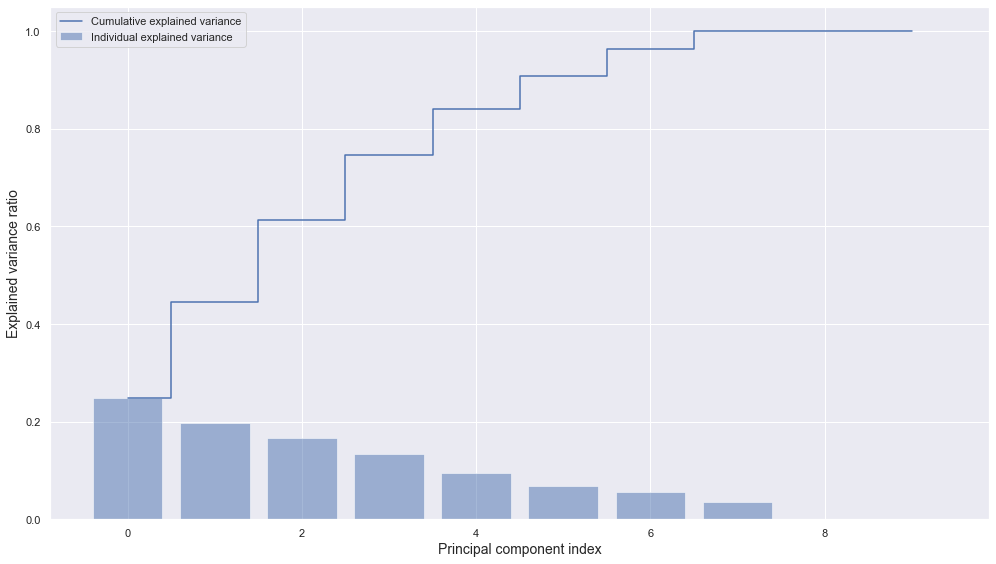

In [181]:
plt.figure(figsize = (14, 8))

plt.bar(range(0,len(pipe.named_steps.pca.explained_variance_ratio_)), pipe.named_steps.pca.explained_variance_ratio_, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(np.cumsum(pipe.named_steps.pca.explained_variance_ratio_))), np.cumsum(pipe.named_steps.pca.explained_variance_ratio_), where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio', fontsize = 14)
plt.xlabel('Principal component index', fontsize = 14)
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

- 4 PC variables can explain almost 80% of total variance.

In [182]:
X_pca[:, :2].shape

(891, 2)

In [183]:
X_pca_scatter = pd.concat([pd.DataFrame(X_pca[:, :2], columns = ["PC1", "PC2"]), pd.DataFrame(titanic_original.is_survived, columns = ["is_survived"])], axis = 1)
X_pca_scatter.head()

,PC1,PC2,is_survived
0,-1.549197,-0.628395,0
1,3.156084,1.732145,1
2,0.455716,-1.295524,1
3,1.562384,-0.519725,1
4,-1.695137,0.025692,0


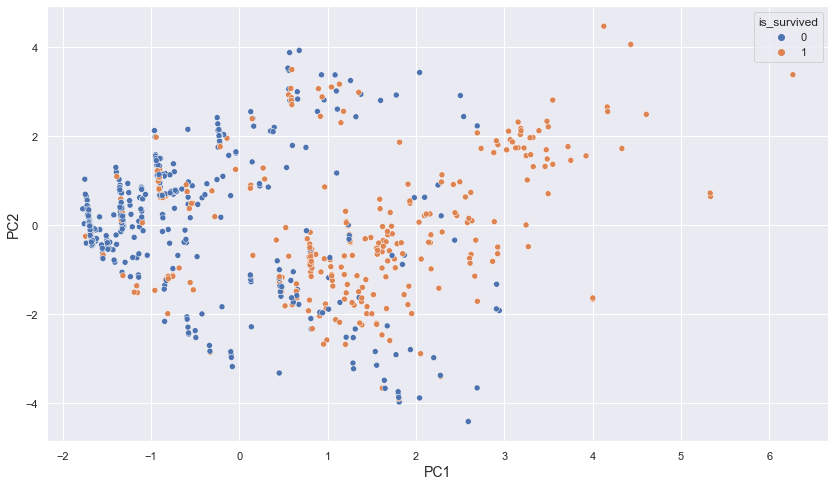

In [184]:
plt.figure(figsize = (14, 8))
sns.scatterplot(data = X_pca_scatter, x = "PC1", y = "PC2", hue = "is_survived")
plt.xlabel("PC1", fontsize = 14)
plt.ylabel("PC2", fontsize = 14)
plt.show()

- It can be seen that we can classify well with PC1, PC2 values.     
    -> Let's do classification with PC1, PC2 variables.


In [185]:
X_pca[:, :2].shape

(891, 2)

In [186]:
X_pca_prep = X_pca[:, :2]

In [187]:
X_train, X_test, y_train, y_test = train_test_split(X_pca_prep, y, test_size = 0.1, random_state = 42)

In [188]:
names = ["Nearest Neighbors", 
         "Linear SVM", 
         "RBF SVM", 
         "Gaussian Process",
         "Decision Tree", 
         "Random Forest", 
         "Neural Net", 
         "AdaBoost",
         "Naive Bayes"
        ]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    ]

In [189]:
for name, clf in zip(names, classifiers):
    try:
        clf.fit(X_train, y_train)
    except:
        clf.fit(X_train.toarray(), y_train)
    
    try:
        y_pred = clf.predict(X_test)
    except: 
        y_pred = clf.predict(X_test.toarray())
    
    # evaluate predictions
    try:
        accuracy = clf.score(X_test, y_test)
    except:
        accuracy = clf.score(X_test.toarray(), y_test)
    
    result_accuracy.loc[result_accuracy.model_name == name, "pca_accuracy"] = round(accuracy * 100, 3)
    #print(f"{name} Accuracy: {round(accuracy * 100, 3)}")

In [190]:
result_accuracy

,model_name,base_accuracy,pca_accuracy
0,Nearest Neighbors,83.333,81.111
1,Linear SVM,81.111,80.000
2,RBF SVM,81.111,82.222
3,Gaussian Process,83.333,80.000
4,Decision Tree,76.667,82.222
5,Random Forest,82.222,81.111
6,Neural Net,76.667,78.889
7,AdaBoost,82.222,78.889
8,Naive Bayes,78.889,81.111


- By using only PC1 and PC2 variables, we can obtain as high accuracy as baseline models.     
- In some models like RBF SVM, Decision Tree, Neural Net, Naive Bayes, PCA variables got higher accuracy than baseline models.

### TSNE

Let's do TSNE and use variabels from TSNE instead of original columns.

In [191]:
X_original_prep.shape

(891, 10)

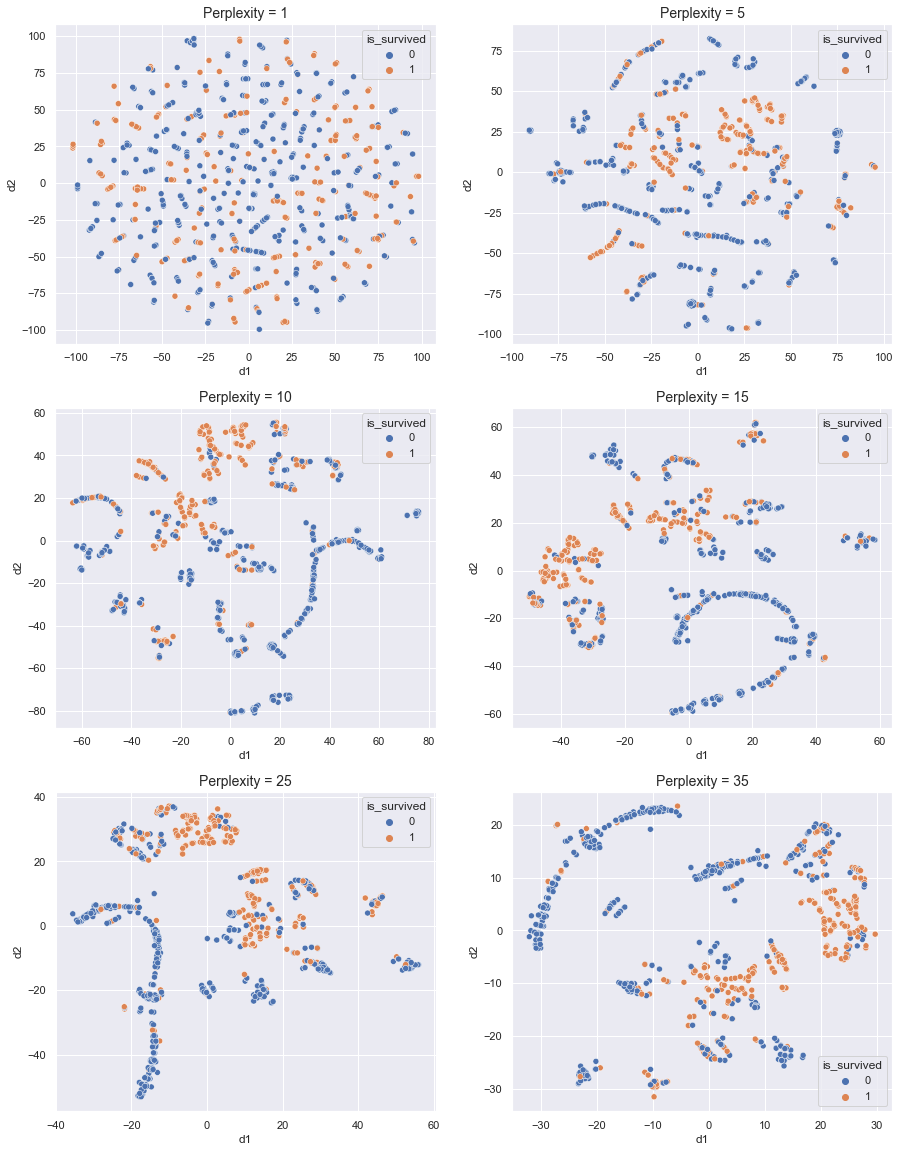

In [192]:
fig, ax = plt.subplots(3, 2, figsize = (15, 20))
for i, perplexity in enumerate([1, 5, 10, 15, 25, 35]):
    tsne = TSNE(n_components = 2, random_state = 42, perplexity = perplexity)
    X_2d = tsne.fit_transform(X_original_prep)
    tsne_labelled = pd.concat([pd.DataFrame(X_2d, columns = ["d1", "d2"]), titanic_original[["is_survived"]].astype(str)], axis = 1)
    
    sns.scatterplot(data = tsne_labelled, x = "d1", y = "d2", hue = "is_survived", ax = ax[i // 2, i % 2])
    ax[i // 2, i % 2].set_title(f"Perplexity = {perplexity}", fontsize = 14)

- From perplexity 15, we can figure out some distinct clusters. And some clusters have a higher rate of survival.      
    -> Let's use higher perplexities.

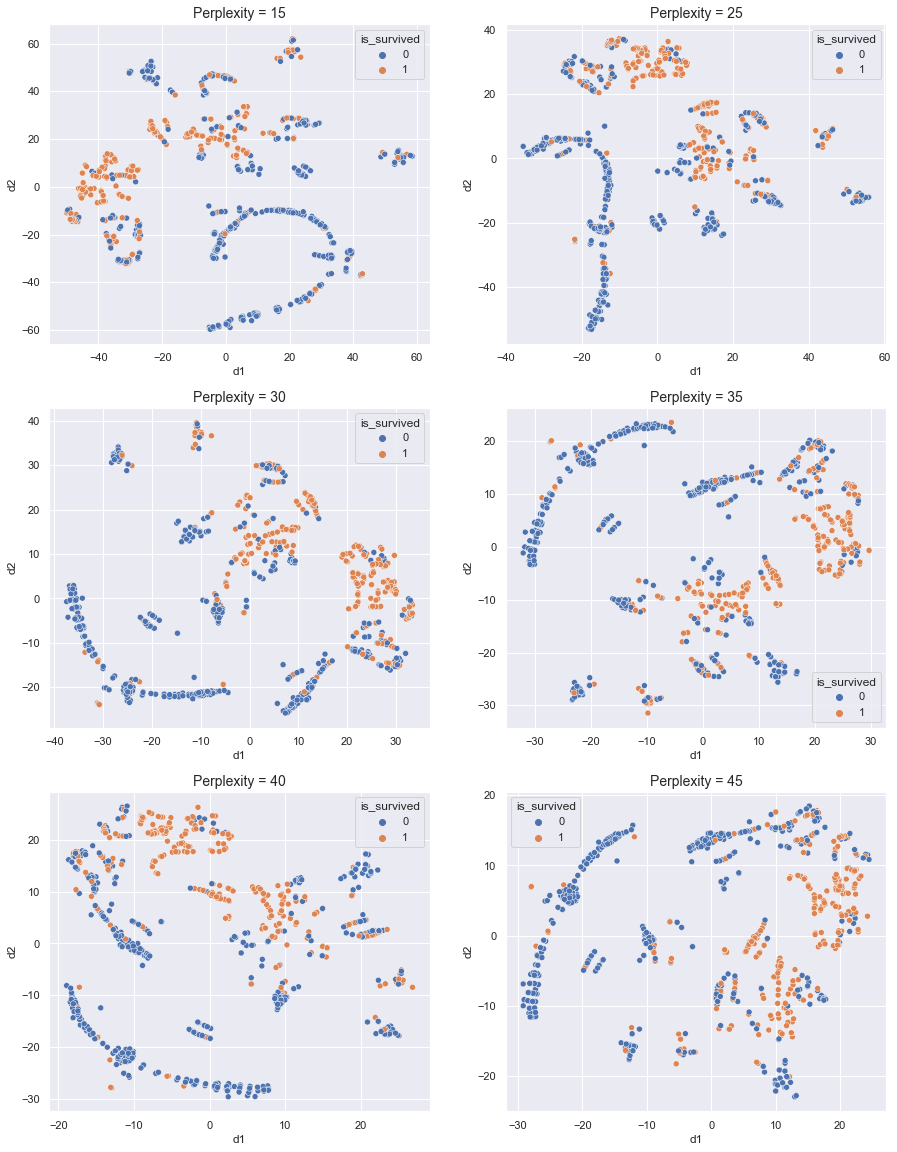

In [193]:
fig, ax = plt.subplots(3, 2, figsize = (15, 20))
for i, perplexity in enumerate([15, 25, 30, 35, 40, 45]):
    tsne = TSNE(n_components = 2, random_state = 42, perplexity = perplexity)
    X_2d = tsne.fit_transform(X_original_prep)
    tsne_labelled = pd.concat([pd.DataFrame(X_2d, columns = ["d1", "d2"]), titanic_original[["is_survived"]].astype(str)], axis = 1)
    
    sns.scatterplot(data = tsne_labelled, x = "d1", y = "d2", hue = "is_survived", ax = ax[i // 2, i % 2])
    ax[i // 2, i % 2].set_title(f"Perplexity = {perplexity}", fontsize = 14)

- From 15, the results are almost similar to each other.
- When perplexity is 25, the distinction between clusters was clear.   
    -> Let's use perplexity = 25

In [194]:
tsne = TSNE(n_components = 2, random_state = 42, perplexity = 25)
X_tsne_prep = tsne.fit_transform(X_original_prep)

In [195]:
X_train, X_test, y_train, y_test = train_test_split(X_tsne_prep, y, test_size = 0.1, random_state = 42)

In [200]:
names = ["Nearest Neighbors", 
         "Linear SVM", 
         "RBF SVM", 
         "Gaussian Process",
         "Decision Tree", 
         "Random Forest", 
         "Neural Net", 
         "AdaBoost",
         "Naive Bayes"
        ]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    ]

for name, clf in zip(names, classifiers):
    try:
        clf.fit(X_train, y_train)
    except:
        clf.fit(X_train.toarray(), y_train)
    
    try:
        y_pred = clf.predict(X_test)
    except: 
        y_pred = clf.predict(X_test.toarray())
    
    # evaluate predictions
    try:
        accuracy = clf.score(X_test, y_test)
    except:
        accuracy = clf.score(X_test.toarray(), y_test)
    
    result_accuracy.loc[result_accuracy.model_name == name, "tsne_accuracy"] = round(accuracy * 100, 3)
    #print(f"{name} Accuracy: {round(accuracy * 100, 3)}")

In [201]:
result_accuracy

,model_name,base_accuracy,pca_accuracy,tsne_accuracy
0,Nearest Neighbors,83.333,81.111,81.111
1,Linear SVM,81.111,80.000,73.333
2,RBF SVM,81.111,82.222,81.111
3,Gaussian Process,83.333,80.000,82.222
4,Decision Tree,76.667,82.222,83.333
5,Random Forest,82.222,81.111,83.333
6,Neural Net,76.667,78.889,76.667
7,AdaBoost,82.222,78.889,76.667
8,Naive Bayes,78.889,81.111,73.333


- By using only 2 variables from tsne, we can obtain as high accuracy as baseline models.
- In Decision Tree and Random Forest, tsne variables got the highest accuracy than baseline or PCA models.

## 3.3. EDA variables

Now, let's use variables from EDA and compare the accuracy with accuracies from methods used before.

In [202]:
titanic.head()

,is_survived,p_class,name,sex,age,num_sb_sp,num_pr_ch,ticket_number,ticket_fare,cabin_number,embark_port,ticket_number_alphabet,ticket_number_number,num_cmp,ticket_fare_category,cabin_alphabet,name_title,age_category,ticket_fare_category_order,age_category_order
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,A/5,21171,1,"(4.010999999999999, 8.676]",n,Mr,"(16.336, 24.294]",1.0,3.0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,PC,17599,1,"(26.25, 512.329]",C,Mrs,"(32.252, 40.21]",3.0,5.0
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,STON/O2.,3101282,0,"(4.010999999999999, 8.676]",n,Miss,"(24.294, 32.252]",1.0,4.0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,non,113803,1,"(26.25, 512.329]",C,Mrs,"(32.252, 40.21]",3.0,5.0
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,non,373450,0,"(4.010999999999999, 8.676]",n,Mr,"(32.252, 40.21]",1.0,5.0


In [203]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   is_survived                 891 non-null    int64   
 1   p_class                     891 non-null    int64   
 2   name                        891 non-null    object  
 3   sex                         891 non-null    object  
 4   age                         891 non-null    float64 
 5   num_sb_sp                   891 non-null    int64   
 6   num_pr_ch                   891 non-null    int64   
 7   ticket_number               891 non-null    object  
 8   ticket_fare                 891 non-null    float64 
 9   cabin_number                204 non-null    object  
 10  embark_port                 891 non-null    object  
 11  ticket_number_alphabet      891 non-null    object  
 12  ticket_number_number        891 non-null    object  
 13  num_cmp             

In [204]:
X = titanic.drop(["is_survived", "name", "ticket_number", "cabin_number", "ticket_number_alphabet", \
                  "ticket_number_number", "cabin_alphabet", "ticket_fare_category", "age_category"], axis = 1)
y = titanic["is_survived"]

In [205]:
X

,p_class,sex,age,num_sb_sp,num_pr_ch,ticket_fare,embark_port,num_cmp,name_title,ticket_fare_category_order,age_category_order
0,3,male,22.000000,1,0,7.2500,S,1,Mr,1.0,3.0
1,1,female,38.000000,1,0,71.2833,C,1,Mrs,3.0,5.0
2,3,female,26.000000,0,0,7.9250,S,0,Miss,1.0,4.0
3,1,female,35.000000,1,0,53.1000,S,1,Mrs,3.0,5.0
4,3,male,35.000000,0,0,8.0500,S,0,Mr,1.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...
886,2,male,27.000000,0,0,13.0000,S,0,uncommon,2.0,4.0
887,1,female,19.000000,0,0,30.0000,S,0,Miss,3.0,3.0
888,3,female,15.685263,1,2,23.4500,S,3,Miss,2.0,2.0
889,1,male,26.000000,0,0,30.0000,C,0,Mr,3.0,4.0


In [206]:
num_features = ["p_class", "age", "num_sb_sp", "num_pr_ch", "ticket_fare", "num_cmp", "ticket_fare_category_order", "age_category_order"]
nonnum_features = ["sex", "embark_port", "name_title"]

In [207]:
full_pipeline = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("nonnum", OneHotEncoder(), nonnum_features),
])

In [210]:
X_eda_prep = full_pipeline.fit_transform(X)

In [211]:
X_train, X_test, y_train, y_test = train_test_split(X_eda_prep, y, test_size = 0.1, random_state = 42)

In [212]:
names = ["Nearest Neighbors", 
         "Linear SVM", 
         "RBF SVM", 
         "Gaussian Process",
         "Decision Tree", 
         "Random Forest", 
         "Neural Net", 
         "AdaBoost",
         "Naive Bayes"
        ]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    ]

In [213]:
for name, clf in zip(names, classifiers):
    try:
        clf.fit(X_train, y_train)
    except:
        clf.fit(X_train.toarray(), y_train)
    
    try:
        y_pred = clf.predict(X_test)
    except: 
        y_pred = clf.predict(X_test.toarray())
    
    # evaluate predictions
    try:
        accuracy = clf.score(X_test, y_test)
    except:
        accuracy = clf.score(X_test.toarray(), y_test)
    
    result_accuracy.loc[result_accuracy.model_name == name, "eda_variables"] = round(accuracy * 100, 3)
    #print(f"{name} Accuracy: {round(accuracy * 100, 3)}")

In [214]:
result_accuracy

,model_name,base_accuracy,pca_accuracy,tsne_accuracy,eda_variables
0,Nearest Neighbors,83.333,81.111,81.111,84.444
1,Linear SVM,81.111,80.000,73.333,82.222
2,RBF SVM,81.111,82.222,81.111,80.000
3,Gaussian Process,83.333,80.000,82.222,84.444
4,Decision Tree,76.667,82.222,83.333,83.333
5,Random Forest,82.222,81.111,83.333,80.000
6,Neural Net,76.667,78.889,76.667,80.000
7,AdaBoost,82.222,78.889,76.667,82.222
8,Naive Bayes,78.889,81.111,73.333,78.889


- In Nearest Neighbors, Linear SVM, Gaussian Process, AdaBoost, eda variables got the highest accuracy than other methods.      
    -> Let's tune Nearest Neighbors, Linear SVM, Gaussian Process, Deicision Tree, and Random Forest and ensemble these models.

## 3.4. Hyperparameter Tuning

Let's tune the hyperparameters for each of 5 models that I will use: Nearest Neighbors, Linear SVM, Gaussian Process, Deicision Tree, and Random Forest.

### Nearest Neighbors

In [216]:
param_grid = {
    'leaf_size': [1, 3, 5, 7, 9],
    'n_neighbors': [1, 3, 5, 7, 9],
    'p' : [1,2]
}

model = KNeighborsClassifier()

eda_knn_grid = GridSearchCV(model, param_grid, cv = 5, n_jobs = -1)
eda_knn_grid.fit(X_eda_prep, y)

print(eda_knn_grid.best_estimator_)
print(eda_knn_grid.best_score_)

KNeighborsClassifier(leaf_size=1, n_neighbors=7)
0.8237838177138912


- Best parameters: leaf_size = 1, n_neighbors = 7
- Best score: about 82%

### Linear SVM

In [217]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01],
}

model = SVC(kernel = "linear")

eda_svm_grid = GridSearchCV(model, param_grid, cv = 5, n_jobs = -1)
eda_svm_grid.fit(X_eda_prep, y)

print(eda_svm_grid.best_estimator_)
print(eda_svm_grid.best_score_)

SVC(C=0.1, gamma=1, kernel='linear')
0.8248948590797817


- Best parameters: c = 0.1, gamma = 1
- Best score: about 82%

### Gaussian Process

In [218]:
param_grid = {
    "kernel": [1 * RBF(), 1 * DotProduct(), 1 * Matern(),  1 * RationalQuadratic(), 1 * WhiteKernel()]
}

model = GaussianProcessClassifier()

eda_gaussian_grid = GridSearchCV(model, param_grid, cv = 5, n_jobs = -1)
eda_gaussian_grid.fit(X_eda_prep, y)

print(eda_gaussian_grid.best_estimator_)
print(eda_gaussian_grid.best_score_)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))
0.8271608813006089


- Best parameters: kernel = 1 ** 2 * RBF(length_scale = 1)
- Best score: about 83%

### Decision tree

In [219]:
param_grid = {
    "splitter":["best","random"],
    "max_depth" : [1,3,5,7,9],
    "min_samples_leaf":[1,2,3],
    "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4],
    "max_features":["auto","log2","sqrt",None],
    "max_leaf_nodes":[None, 20, 40, 60]
}

model = DecisionTreeClassifier()

eda_decision_tree_grid = GridSearchCV(model, param_grid, cv = 5, n_jobs = -1)
eda_decision_tree_grid.fit(X_eda_prep, y)

print(eda_decision_tree_grid.best_estimator_)
print(eda_decision_tree_grid.best_score_)

DecisionTreeClassifier(max_depth=9, max_features='auto', max_leaf_nodes=40,
                       min_samples_leaf=2, min_weight_fraction_leaf=0.2)
0.7968740192078337


- Best parameters: max_depth = 7, max_features = "sqrt", max_leaf_nodes = 60, min_samples_leaf = 3, min_weight_fraction_leaf = 0.1
- Best score: about 80%

### Random forest

In [220]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 30, 50],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [5, 10, 15, 20]
}

model = RandomForestClassifier()

eda_random_forest_grid = GridSearchCV(model, param_grid, cv = 5, n_jobs = -1)
eda_random_forest_grid.fit(X_eda_prep, y)

print(eda_random_forest_grid.best_estimator_)
print(eda_random_forest_grid.best_score_)

RandomForestClassifier(max_depth=30, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=20)
0.8439834285355596


- Best parameters: bootstrap = False, max_depth = 10, miin_samples_leaf = 4, min_samples_split = 10, n_estimators = 15
- Best score: about 85%

## 3.5. Ensemble Models

Now, let's tune classfiers and ensemble these models.

### Nearest Neighbors, Linear SVM, Gaussian Process

In [221]:
X = titanic.drop(["is_survived", "name", "ticket_number", "cabin_number", "ticket_number_alphabet", \
                  "ticket_number_number", "cabin_alphabet", "ticket_fare_category", "age_category"], axis = 1)
y = titanic["is_survived"]

In [222]:
num_features = ["p_class", "age", "num_sb_sp", "num_pr_ch", "ticket_fare", "num_cmp", "ticket_fare_category_order", "age_category_order"]
nonnum_features = ["sex", "embark_port", "name_title"]

In [223]:
full_pipeline = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("nonnum", OneHotEncoder(), nonnum_features),
])

In [224]:
X_eda_prep = full_pipeline.fit_transform(X)

In [225]:
X_train, X_test, y_train, y_test = train_test_split(X_eda_prep, y, test_size = 0.1, random_state = 42)


In [226]:
clf_knn = KNeighborsClassifier(leaf_size = eda_knn_grid.best_params_["leaf_size"], n_neighbors = eda_knn_grid.best_params_["n_neighbors"])

clf_svc = SVC(kernel = "linear", C = eda_svm_grid.best_params_["C"], gamma = eda_svm_grid.best_params_["gamma"])

clf_gaussian_process = GaussianProcessClassifier(kernel = eda_gaussian_grid.best_params_["kernel"])


clf_decision_tree = DecisionTreeClassifier(
    max_depth = eda_decision_tree_grid.best_params_["max_depth"],
    max_features = eda_decision_tree_grid.best_params_["max_features"],
    max_leaf_nodes = eda_decision_tree_grid.best_params_["max_leaf_nodes"],
    min_samples_leaf = eda_decision_tree_grid.best_params_["min_samples_leaf"],
    min_weight_fraction_leaf = eda_decision_tree_grid.best_params_["min_weight_fraction_leaf"],
    splitter = eda_decision_tree_grid.best_params_["splitter"],
)

clf_random_forest = RandomForestClassifier(
    bootstrap = eda_random_forest_grid.best_params_["bootstrap"],
    max_depth = eda_random_forest_grid.best_params_["max_depth"],
    max_features = eda_random_forest_grid.best_params_["max_features"],
    min_samples_leaf = eda_random_forest_grid.best_params_["min_samples_leaf"],
    min_samples_split = eda_random_forest_grid.best_params_["min_samples_split"],
    n_estimators = eda_random_forest_grid.best_params_["n_estimators"],
)

In [227]:
clf_ensemble = VotingClassifier(
    estimators = [("knn", clf_knn), ("svc", clf_svc), ("gp", clf_gaussian_process),
                  ("dt", clf_decision_tree), ("rf", clf_random_forest)], 
    voting = "hard"
)

In [228]:
clf_ensemble = clf_ensemble.fit(X_train, y_train)
y_pred = clf_ensemble.predict(X_test)
accuracy = clf_ensemble.score(X_test, y_test)

round(accuracy * 100, 3)

82.222

- Get about 82% accuracy from the ensemble model.

# 4. Prepare submission

In [229]:
X.head()

,p_class,sex,age,num_sb_sp,num_pr_ch,ticket_fare,embark_port,num_cmp,name_title,ticket_fare_category_order,age_category_order
0,3,male,22.0,1,0,7.2500,S,1,Mr,1.0,3.0
1,1,female,38.0,1,0,71.2833,C,1,Mrs,3.0,5.0
2,3,female,26.0,0,0,7.9250,S,0,Miss,1.0,4.0
3,1,female,35.0,1,0,53.1000,S,1,Mrs,3.0,5.0
4,3,male,35.0,0,0,8.0500,S,0,Mr,1.0,5.0


In [230]:
test = test[X.columns]
test.head()

,p_class,sex,age,num_sb_sp,num_pr_ch,ticket_fare,embark_port,num_cmp,name_title,ticket_fare_category_order,age_category_order
0,3,male,34.5,0,0,7.8292,Q,0,Mr,1.0,5.0
1,3,female,47.0,1,0,7.0000,S,1,Mrs,1.0,6.0
2,2,male,62.0,0,0,9.6875,Q,0,Mr,2.0,8.0
3,3,male,27.0,0,0,8.6625,S,0,Mr,1.0,4.0
4,3,female,22.0,1,1,12.2875,S,2,Mrs,2.0,3.0


In [231]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   p_class                     418 non-null    int64  
 1   sex                         418 non-null    object 
 2   age                         418 non-null    float64
 3   num_sb_sp                   418 non-null    int64  
 4   num_pr_ch                   418 non-null    int64  
 5   ticket_fare                 418 non-null    float64
 6   embark_port                 418 non-null    object 
 7   num_cmp                     418 non-null    int64  
 8   name_title                  418 non-null    object 
 9   ticket_fare_category_order  418 non-null    float64
 10  age_category_order          418 non-null    float64
dtypes: float64(4), int64(4), object(3)
memory usage: 39.2+ KB


In [232]:
X_submission_prep = full_pipeline.transform(test)

In [233]:
y_pred = clf_ensemble.predict(X_submission_prep)

In [234]:
submission = pd.DataFrame({
    "PassengerId": test_passenger_id,
    "Survived": y_pred
})

submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [235]:
#submission.to_csv('./data/titanic_submission.csv', index=False)

![title](titanic_submission.png)